In [1]:
#Ap. de Goiânia ####################################################

import pandas as pd
import numpy as np
import scipy
from datetime import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
from scipy.optimize import leastsq, minimize
from scipy import special
from scipy import integrate
import math
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from reliability.Distributions import Weibull_Distribution, Mixture_Model, Gamma_Distribution, Loglogistic_Distribution, Lognormal_Distribution
from reliability.Fitters import Fit_Weibull_2P, Fit_Weibull_Mixture, Fit_Gamma_2P, Fit_Lognormal_2P, Fit_Loglogistic_2P
from reliability.Probability_plotting import plot_points
from reliability.Other_functions import make_right_censored_data, histogram
from reliability.Fitters import Fit_Everything
from reliability.ALT_fitters import Fit_Everything_ALT
from reliability.Probability_plotting import Weibull_probability_plot
import xlwt
plt.style.use('seaborn-darkgrid')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 

In [2]:
def moving_average(data_x, window):
    return np.convolve(data_x, np.ones(window), 'valid') / window

In [3]:
#Colocar o arquivo do Nasa Power com média horária na mesma pasta que o script
ap_data = pd.read_csv('./POWER_Point_Hourly_20010101_20220331.csv', sep=',', header=10)

In [4]:
#Converte columnas YY-MO-DY ao formato datetime
ap_data.columns = ["Year", "Month", "Day", "Hour" , "Wind Direction", "Wind Speed"]
#ap_data.head(5)

In [5]:
#Crea uma coluna Date com valores datetime e a coloca como index
ap_data['Date'] = pd.to_datetime(ap_data[['Year','Month', 'Day', 'Hour']])
ap_data.set_index('Date', inplace=True) # inplace implementa o set index
data_to_sasonal = ap_data.copy() #copia o conteudo do df e não a posisão de memoria
#ap_data.head(5)
#data.info()

In [6]:
data_to_sasonal

,Year,Month,Day,Hour,Wind Direction,Wind Speed
Date,,,,,,
2000-12-31 21:00:00,2000,12,31,21,247.36,1.79
2000-12-31 22:00:00,2000,12,31,22,255.37,1.64
2000-12-31 23:00:00,2000,12,31,23,264.46,1.3
2001-01-01 00:00:00,2001,1,1,0,300.22,0.82
2001-01-01 01:00:00,2001,1,1,1,342.13,1.25
...,...,...,...,...,...,...
2022-03-31 16:00:00,2022,3,31,16,61.77,1.68
2022-03-31 17:00:00,2022,3,31,17,79.88,1.33
2022-03-31 18:00:00,2022,3,31,18,96.15,1.02


In [7]:
#Crea uma coluna DoY (day of year) com os dias do ano e logo cria multindex
ap_data['DoY'] = ap_data.index.dayofyear
ap_data.reset_index(inplace=True)
ap_data.insert(0, 'HoY', (ap_data.DoY-1)*24 + ap_data.Hour)
ap_data.set_index(['DoY', 'HoY', 'Date'], inplace=True) #multindex
ap_data.tail(10)

Year  Month  Day  Hour  Wind Direction  Wind Speed
DoY HoY  Date                                                                   
90  2147 2022-03-31 11:00:00  2022      3   31    11           50.25        4.89
    2148 2022-03-31 12:00:00  2022      3   31    12           48.56        4.36
    2149 2022-03-31 13:00:00  2022      3   31    13           48.47        3.65
    2150 2022-03-31 14:00:00  2022      3   31    14           50.66        2.97
    2151 2022-03-31 15:00:00  2022      3   31    15           54.98        2.33
    2152 2022-03-31 16:00:00  2022      3   31    16           61.77        1.68
    2153 2022-03-31 17:00:00  2022      3   31    17           79.88        1.33
    2154 2022-03-31 18:00:00  2022      3   31    18           96.15        1.02
    2155 2022-03-31 19:00:00  2022      3   31    19          123.97        0.89
    2156 2022-03-31 20:00:00  2022      3   31    20          148.91         1.2

In [8]:
# agrupamento  
ws_meanxhora = ap_data['Wind Speed'].groupby([ap_data.Year, ap_data.Month, ap_data.Day, ap_data.Hour]).mean().to_frame()
ws_meanxhora

Wind Speed
Year Month Day Hour            
2000 12    31  21          1.79
               22          1.64
               23           1.3
2001 1     1   0           0.82
               1           1.25
...                         ...
2022 3     31  16          1.68
               17          1.33
               18          1.02
               19          0.89
               20           1.2

[186240 rows x 1 columns]

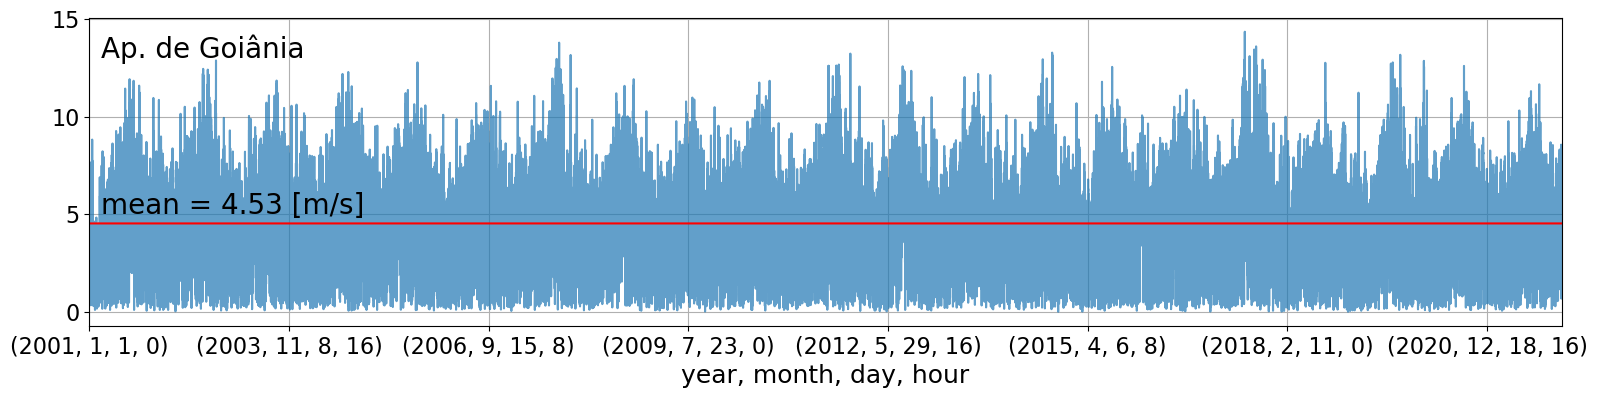

In [9]:
plt.style.use('default')
ws_meanxhora['Wind Speed'][3:-24*78].plot(alpha=0.7, style='-', figsize=(19,4))
n_ws = len(ws_meanxhora['Wind Speed'][3:-24*78])
MEAN=np.ones(n_ws)*ws_meanxhora['Wind Speed'].mean()
plt.plot(range(n_ws), MEAN, 'red')
plt.xlabel('year, month, day, hour', size=18)
#plt.ylabel('Wind Speed [m/s]', size=16)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal")
t_text = 'mean = ' + str(round(MEAN[0], 2)) + ' [m/s]'  
plt.text(1500, 5, t_text, fontsize=20)
plt.text(1500, 13, 'Ap. de Goiânia', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(visible=True)
plt.savefig('Ap_de_Goiânia_Serie temporal.png', dpi=300)

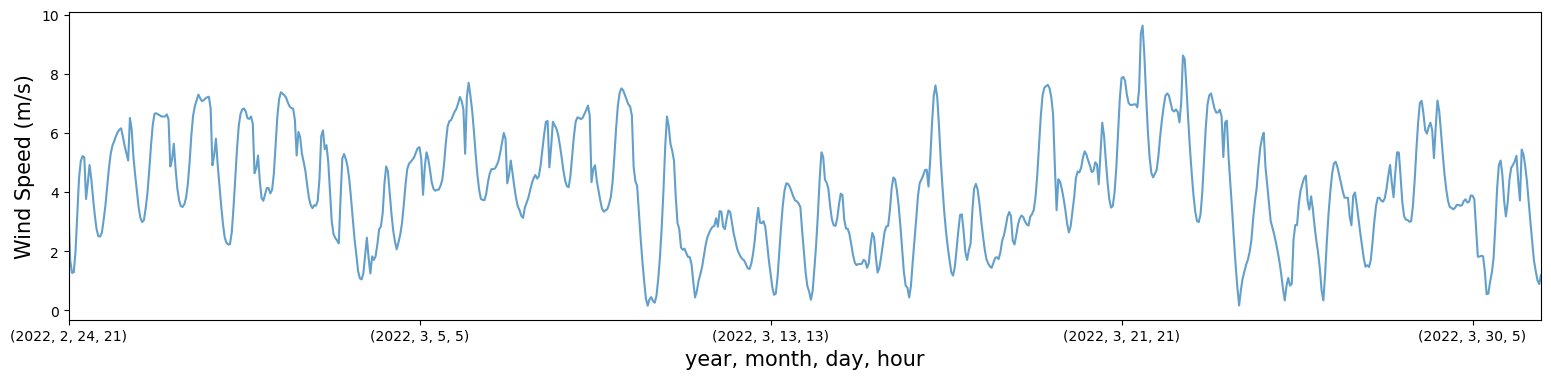

In [10]:
ws_meanxhora['Wind Speed'][185400:].plot(alpha=0.7, style='-', figsize=(19,4))
plt.xlabel('year, month, day, hour', size=15)
plt.ylabel('Wind Speed (m/s)', size=15)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal22_AP")

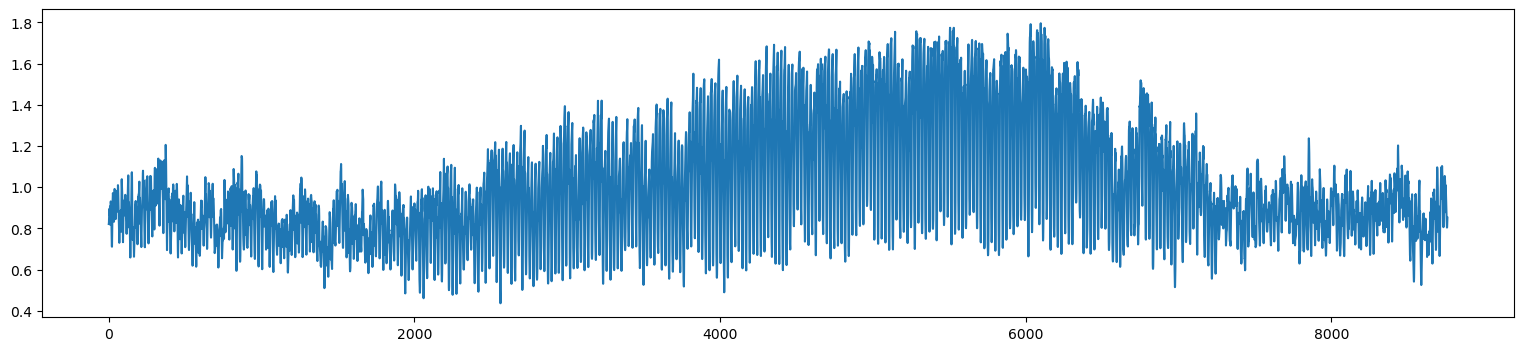

In [11]:
data_x = ws_meanxhora['Wind Speed'].to_numpy()
window = int(np.floor(24*365)) # largura da janela da média móvel T periodo  
ma = moving_average(data_x, window) #média móvel centrada
mean_ma = np.mean(ma) #média da média movel centrada
isi = data_x[0:-8759]/ma  #indice de sazonalidade individual

index_saz = [np.mean(isi[i::window]) for i in range(window)] #indice de sazonalidade

plt.figure(figsize=(19,4))
plt.plot(range(len(index_saz[:])), index_saz[:])
#plt.plot(range(len(ma[:800])), ma[:800])

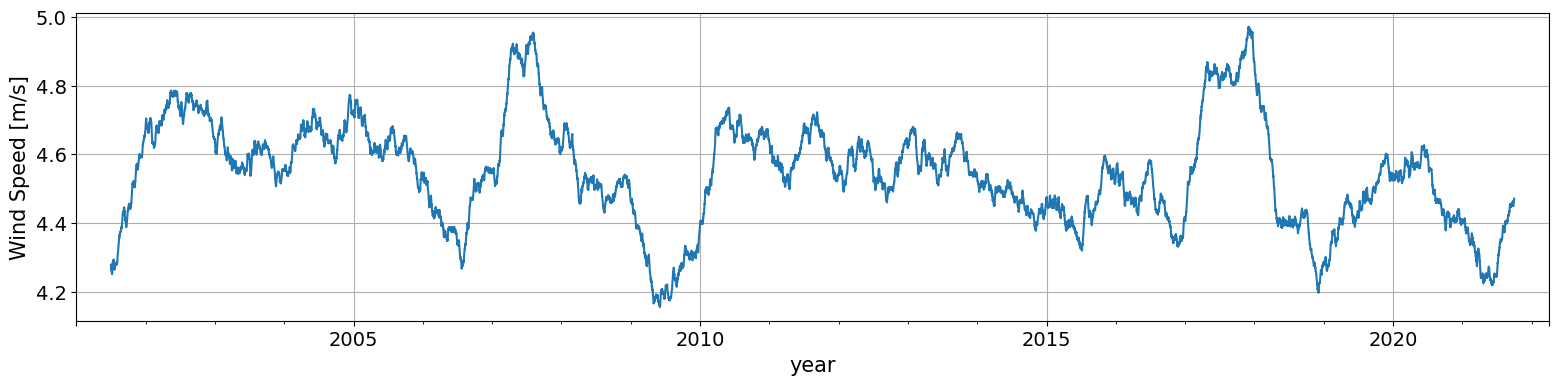

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_A=seasonal_decompose(data_to_sasonal['Wind Speed'], period=24*365, model='aditive')
seasonal_A.trend[:].plot(figsize=(19,4))
plt.xlabel('year', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal")
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xticks()
plt.grid(visible=True)
plt.show()

In [13]:
type(seasonal.seasonal[3:200])

NameError: name 'seasonal' is not defined

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal=seasonal_decompose(data_to_sasonal['Wind Speed'], period=24, model='aditive')
seasonal.seasonal[3:100].plot(figsize=(19,4))
plt.xlabel('year', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal")
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xticks()
plt.grid(visible=True)
plt.show()

In [ ]:
seasonal.seasonal[3:100].plot(figsize=(19,4))

In [ ]:
y_1 = data_to_sasonal['Wind Speed']-seasonal.seasonal
seasonal_1=seasonal_decompose(y_1, period=24*365, model='aditive')
seasonal_1.seasonal[3:20000].plot(figsize=(19,4))
plt.xlabel('year', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal")
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xticks()
plt.grid(visible=True)
plt.show()

In [ ]:
y_2 = y_1 - seasonal_1.seasonal 
y_2 = y_2 + seasonal.seasonal
seasonal_2 = seasonal_decompose(y_2, period=24, model='aditive')
seasonal_2.seasonal[3:200].plot(figsize=(19,4))
plt.xlabel('year', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal")
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xticks()
plt.grid(visible=True)
plt.show()

In [ ]:
y_3 = y_2 - seasonal_2.seasonal 
y_3 = y_3 + seasonal_1.seasonal
seasonal_3 = seasonal_decompose(y_3, period=24*365, model='aditive')
seasonal_3.seasonal[3:200].plot(figsize=(19,4))
plt.xlabel('year', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal")
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xticks()
plt.grid(visible=True)
plt.show()

In [ ]:
sss=seasonal_A.seasonal-seasonal.seasonal
sss[0:10000].plot()

In [ ]:
#Daily Sasonality
ws_seasonality = ap_data['Wind Speed'].groupby([ap_data.Hour]).mean().to_frame()
plt.figure(figsize=(19,6))
list_ws_saz = list(ws_seasonality.index)
list_ws_saz.append(24)
list_ws_saz2=list(ws_seasonality['Wind Speed']-MEAN[0])
list_ws_saz2.append(ws_seasonality['Wind Speed'][0]-MEAN[0]) 
plt.plot(list_ws_saz, list_ws_saz2) 
plt.xlabel('Hour', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
plt.margins(x=0.0, y=0.05)
plt.grid(visible=True)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.legend(        # The line objects           
#           labels=["Wind Speed", "$\sigma^2$"],   # The labels for each line
#           loc="lower right",    # Position of legend
#           borderaxespad=0.1,    # Small spacing around legend box
#           fontsize=13
#           #title=""             # Title for the legend
#           )
#plt.savefig("Sazonalidade Diária2")

In [ ]:
#Daily Sasonality
ws_seasonality = ap_data['Wind Speed'].groupby([ap_data.Hour]).mean().to_frame()
ws_seasonality_var = ap_data['Wind Speed'].groupby([ap_data.Hour]).std().to_frame()
plt.figure(figsize=(19,8))

plt.plot(ws_seasonality.index, ws_seasonality, ws_seasonality_var.index, ws_seasonality_var) 
plt.xlabel('Hour', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
#plt.title('Daily Sasonality', size=15)
plt.grid(visible=True)
plt.margins(x=0.0, y=0.05)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(        # The line objects           
           labels=["Wind Speed", "$\sigma$"],   # The labels for each line
           loc="lower right",    # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           fontsize=13
           #title=""             # Title for the legend
           )
plt.savefig("Sazonalidade Diária2")

In [ ]:
list_ws_saz2=list(ws_seasonality['Wind Speed'])
ws_seasonality['Wind Speed']

In [ ]:
ap_data['Wind Speed'][4379:-4380]-ma


In [14]:
ws_seasonality

NameError: name 'ws_seasonality' is not defined

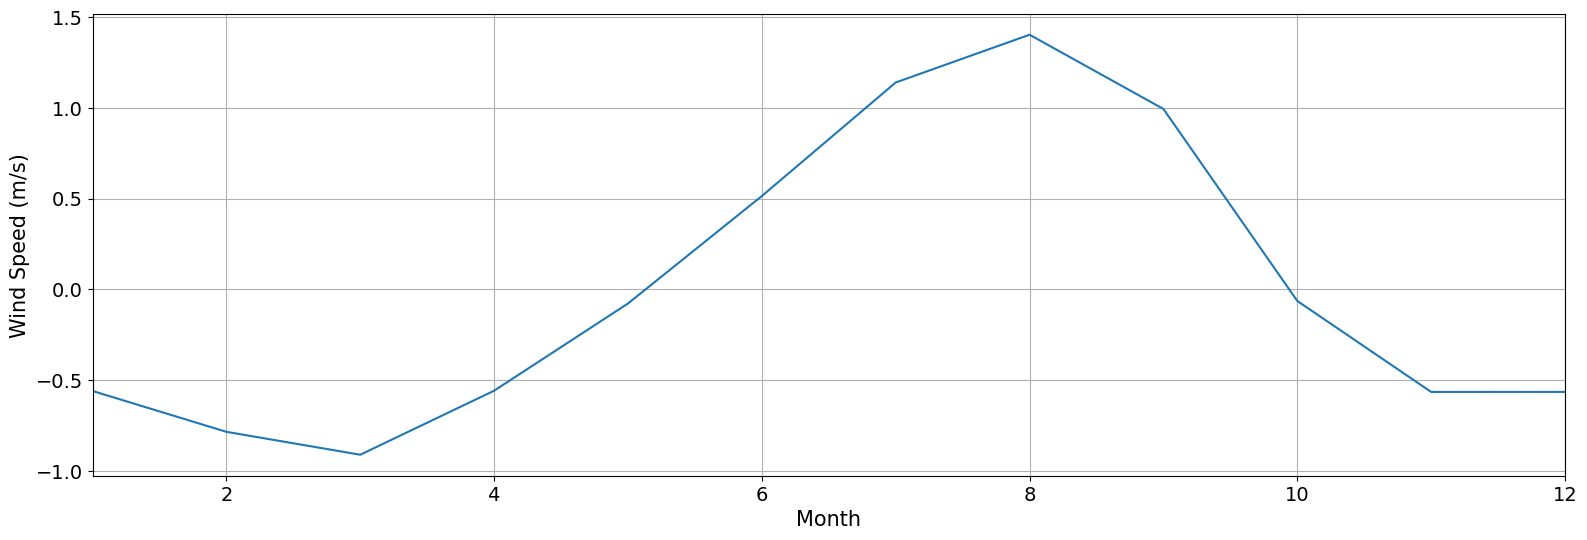

In [15]:
#Yearly Sasonality
ws_seasonality = (ap_data['Wind Speed'][4379:-4380]-ma).groupby([ap_data.Month]).mean().to_frame()
plt.figure(figsize=(19,6))
list_ws_saz = list(ws_seasonality.index)
#list_ws_saz.append(13)
list_ws_saz2=list(ws_seasonality['Wind Speed'])
#list_ws_saz2.append(ws_seasonality['Wind Speed'][1])
plt.plot(list_ws_saz, list_ws_saz2) 
plt.xlabel('Month', size=15)
plt.ylabel('Wind Speed (m/s)', size=15)
plt.margins(x=0.0, y=0.05)
plt.grid(visible=True)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.legend(        # The line objects           
#           labels=["Wind Speed", "$\sigma^2$"],   # The labels for each line
#           loc="upper right",    # Position of legend
#           borderaxespad=0.1,    # Small spacing around legend box
#           fontsize=13       
#           #title=""           # Title for the legend
#           )
plt.savefig("Sazonalidade Mensal_2_Fortim")

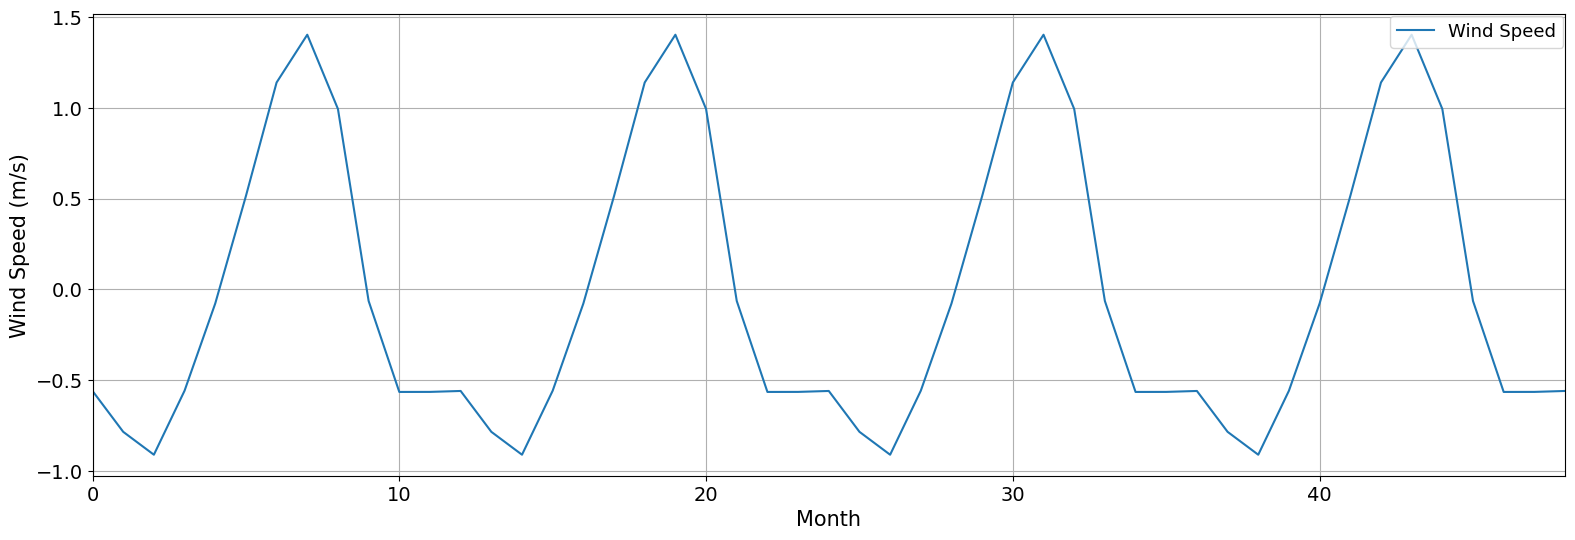

In [16]:
list_ws_saz_a = list_ws_saz2[0:12] * 21
#Yearly Sasonality
plt.figure(figsize=(19,6))
plt.plot(range(len(list_ws_saz_a[0:49])), list_ws_saz_a[0:49]) 
plt.xlabel('Month', size=15)
plt.ylabel('Wind Speed (m/s)', size=15)
#plt.title('Monthly Sasonality', size=15)
plt.margins(x=0.0, y=0.05)
plt.grid(visible=True)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(        # The line objects           
           labels=["Wind Speed", "$\sigma^2$"],   # The labels for each line
           loc="upper right",    # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           fontsize=13       
           #title=""           # Title for the legend
           )
plt.savefig("Sazonalidade Mensal2")

In [17]:
len(np.array(list_ws_saz_a))

252

In [18]:
y_22 = data_to_sasonal['Wind Speed']-seasonal.seasonal-MEAN[0]-seasonal_1.seasonal
#seasonal_1=seasonal_decompose(y_1, period=24*365, model='aditive')
y_22[0:].plot(figsize=(19,4))
plt.xlabel('year', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
plt.margins(x=0.0, y=0.05)
plt.savefig("Serie temporal")
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xticks()
plt.grid(visible=True)
plt.show()

NameError: name 'seasonal' is not defined

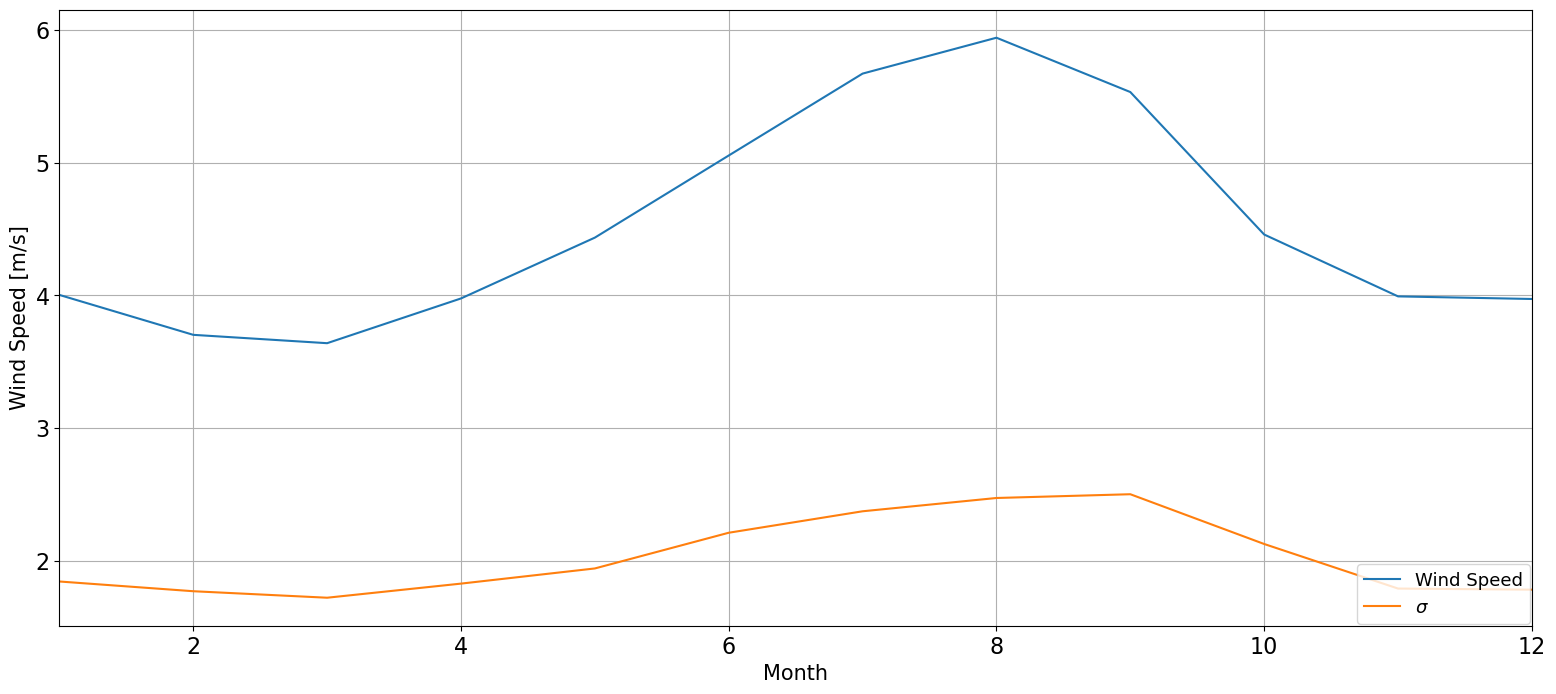

In [36]:
#Yearly Sasonality
ws_seasonality = ap_data['Wind Speed'].groupby([ap_data.Month]).mean().to_frame()
ws_seasonality_var = ap_data['Wind Speed'].groupby([ap_data.Month]).std().to_frame()
plt.figure(figsize=(19,8))
plt.plot(ws_seasonality.index, ws_seasonality, ws_seasonality_var.index, ws_seasonality_var) 
plt.xlabel('Month', size=15)
plt.ylabel('Wind Speed [m/s]', size=15)
#plt.title('Daily Sasonality', size=15)
plt.grid(visible=True)
plt.margins(x=0.0, y=0.05)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(        # The line objects           
           labels=["Wind Speed", "$\sigma$"],   # The labels for each line
           loc="lower right",    # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           fontsize=13
           #title=""             # Title for the legend
           )
plt.savefig("Sazonalidade Mensal2")

In [37]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import IPython
import IPython.display

In [38]:
ap_data2 = pd.DataFrame()
ap_data2['date'] = ap_data.index.get_level_values(level='Date')
ap_data2['Wind_speed'] = list(ap_data['Wind Speed'])
ap_data2['Wind_direction'] = list(ap_data['Wind Direction'])

In [39]:
ss=seasonal.seasonal.to_frame()
ss

NameError: name 'seasonal' is not defined

In [40]:
day = 24*60*60
year = (365.2425)*day
timestamp_s = ap_data2["date"].map(pd.Timestamp.timestamp) #ss.index.map(pd.Timestamp.timestamp)

In [41]:
1/day

1.1574074074074073e-05

In [42]:
fft = tf.signal.rfft(ss['seasonal'])  #(ap_data2['Wind_speed'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(ss['seasonal'])#(ap_data2['Wind_speed'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h*3600#/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
#plt.step(f_per_year, np.abs(fft))
Sx=abs(fft) / len(ss['seasonal'])#(ap_data2['Wind_speed'])
plt.plot(f_per_year, Sx)
plt.xscale('log')
plt.ylim(0, 1)
plt.ylabel('Wind Speed [m/s]')
#plt.xlim([0.1, max(plt.xlim())])
#plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.grid(visible=True)
plt.tick_params(axis='both', which='major', labelsize=10)
_ = plt.xlabel('Frequency [log scale]')
plt.savefig("FFT")

NameError: name 'ss' is not defined

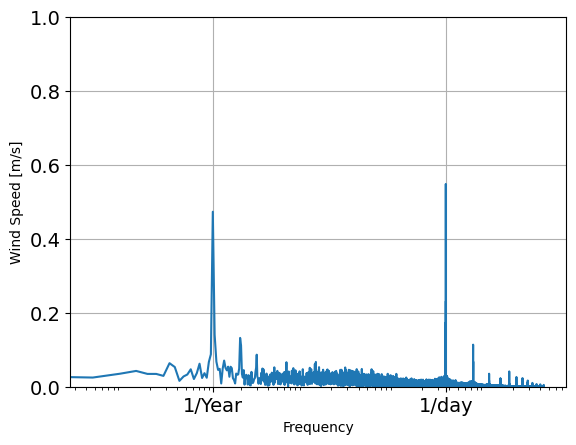

In [43]:
fft = tf.signal.rfft(ap_data2['Wind_speed'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(ap_data2['Wind_speed'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
#plt.step(f_per_year, np.abs(fft))
Sx=abs(fft) / len(ap_data2['Wind_speed'])
plt.plot(f_per_year, Sx)
plt.xscale('log')
plt.ylim(0, 1)
plt.ylabel('Wind Speed [m/s]')
#plt.xlim([-3, 870])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
plt.grid(visible=True)
plt.tick_params(axis='both', which='major', labelsize=14)
_ = plt.xlabel('Frequency')
#plt.savefig("FFT2")

In [44]:
#Cria a tabela (formato dataframe) de comparação entre as diferentes distribuições horárias
#tabela dos valores da qualidade do ajuste
table_gof=pd.DataFrame()

table_gof['PDF'] = ["W-W", "W", "G", "LN", "LL" ]
table_gof.set_index(['PDF'], inplace=True)

table_gof['LogL 00']=0.00
table_gof['AICc 00']=0.00
table_gof['BIC 00']=0.00 
table_gof['AD 00']=0.00

table_gof['LogL 01']=0.00
table_gof['AICc 01']=0.00
table_gof['BIC 01']=0.00 
table_gof['AD 01']=0.00

table_gof['LogL 02']=0.00
table_gof['AICc 02']=0.00
table_gof['BIC 02']=0.00 
table_gof['AD 02']=0.00

table_gof['LogL 03']=0.00
table_gof['AICc 03']=0.00
table_gof['BIC 03']=0.00 
table_gof['AD 03']=0.00

table_gof['Log 04']=0.00
table_gof['AICc 04']=0.00
table_gof['BIC 04']=0.00 
table_gof['AD 04']=0.00

table_gof['LogL 05']=0.00
table_gof['AICc 05']=0.00
table_gof['BIC 05']=0.00 
table_gof['AD 05']=0.00

table_gof['LogL 06']=0.00
table_gof['AICc 06']=0.00
table_gof['BIC 06']=0.00 
table_gof['AD 06']=0.00

table_gof['LogL 07']=0.00
table_gof['AICc 07']=0.00
table_gof['BIC 07']=0.00 
table_gof['AD 07']=0.00

table_gof['LogL 08']=0.00
table_gof['AICc 08']=0.00
table_gof['BIC 08']=0.00 
table_gof['AD 08']=0.00

table_gof['LogL 09']=0.00
table_gof['AICc 09']=0.00
table_gof['BIC 09']=0.00 
table_gof['AD 09']=0.00

table_gof['LogL 10']=0.00
table_gof['AICc 10']=0.00
table_gof['BIC 10']=0.00 
table_gof['AD 10']=0.00

table_gof['LogL 11']=0.00
table_gof['AICc 11']=0.00
table_gof['BIC 11']=0.00 
table_gof['AD 11']=0.00

table_gof['LogL 12']=0.00
table_gof['AICc 12']=0.00
table_gof['BIC 12']=0.00 
table_gof['AD 12']=0.00

table_gof['LogL 13']=0.00
table_gof['AICc 13']=0.00
table_gof['BIC 13']=0.00 
table_gof['AD 13']=0.00

table_gof['LogL 14']=0.00
table_gof['AICc 14']=0.00
table_gof['BIC 14']=0.00 
table_gof['AD 14']=0.00

table_gof['LogL 15']=0.00
table_gof['AICc 15']=0.00
table_gof['BIC 15']=0.00 
table_gof['AD 15']=0.00

table_gof['LogL 16']=0.00
table_gof['AICc 16']=0.00
table_gof['BIC 16']=0.00 
table_gof['AD 16']=0.00

table_gof['LogL 17']=0.00
table_gof['AICc 17']=0.00
table_gof['BIC 17']=0.00 
table_gof['AD 17']=0.00

table_gof['LogL 18']=0.00
table_gof['AICc 18']=0.00
table_gof['BIC 18']=0.00 
table_gof['AD 18']=0.00

table_gof['LogL 19']=0.00
table_gof['AICc 19']=0.00
table_gof['BIC 19']=0.00 
table_gof['AD 19']=0.00

table_gof['LogL 20']=0.00
table_gof['AICc 20']=0.00
table_gof['BIC 20']=0.00 
table_gof['AD 20']=0.00

table_gof['LogL 21']=0.00
table_gof['AICc 21']=0.00
table_gof['BIC 21']=0.00 
table_gof['AD 21']=0.00

table_gof['LogL 22']=0.00
table_gof['AICc 22']=0.00
table_gof['BIC 22']=0.00 
table_gof['AD 22']=0.00

table_gof['LogL 23']=0.00
table_gof['AICc 23']=0.00
table_gof['BIC 23']=0.00 
table_gof['AD 23']=0.00

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

table_gof.style.set_caption('$goodness$ $of$ $fit$').set_table_styles(styles)# permite apresentar um título na tabela

,LogL 00,AICc 00,BIC 00,AD 00,LogL 01,AICc 01,BIC 01,AD 01,LogL 02,AICc 02,BIC 02,AD 02,LogL 03,AICc 03,BIC 03,AD 03,Log 04,AICc 04,BIC 04,AD 04,LogL 05,AICc 05,BIC 05,AD 05,LogL 06,AICc 06,BIC 06,AD 06,LogL 07,AICc 07,BIC 07,AD 07,LogL 08,AICc 08,BIC 08,AD 08,LogL 09,AICc 09,BIC 09,AD 09,LogL 10,AICc 10,BIC 10,AD 10,LogL 11,AICc 11,BIC 11,AD 11,LogL 12,AICc 12,BIC 12,AD 12,LogL 13,AICc 13,BIC 13,AD 13,LogL 14,AICc 14,BIC 14,AD 14,LogL 15,AICc 15,BIC 15,AD 15,LogL 16,AICc 16,BIC 16,AD 16,LogL 17,AICc 17,BIC 17,AD 17,LogL 18,AICc 18,BIC 18,AD 18,LogL 19,AICc 19,BIC 19,AD 19,LogL 20,AICc 20,BIC 20,AD 20,LogL 21,AICc 21,BIC 21,AD 21,LogL 22,AICc 22,BIC 22,AD 22,LogL 23,AICc 23,BIC 23,AD 23
PDF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
W-W,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
W,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [45]:
#tabela dos valores médios da qualidade do ajuste das PDFs horárias
table_gof_mean=pd.DataFrame()

table_gof_mean['PDF'] = ["W-W", "W", "G", "LN", "LL" ]
table_gof_mean.set_index(['PDF'], inplace=True)

table_gof_mean['LogL'] = 0.00
table_gof_mean['AICc'] = 0.00
table_gof_mean['BIC'] = 0.00 
table_gof_mean['AD'] = 0.00
table_gof_mean

,LogL,AICc,BIC,AD
PDF,,,,
W-W,0,0,0,0
W,0,0,0,0
G,0,0,0,0
LN,0,0,0,0
LL,0,0,0,0


In [46]:
#Cria a tabela (formato dataframe) de comparação de DPV entre as diferentes PDFs horárias
table4=pd.DataFrame()

table4['Hour'] = ['00', '01', '02', '03','04','05','06','07','08','09','10','11','12','13','14','15',
                  '16','17','18','19', '20', '21','22','23']
table4['Data Pot']=0.00
table4['TC-Weibull Pot']=0.00 
table4['Weibull Pot']=0.00
table4['Gamma Pot']=0.00
table4['Log-Normal Pot']=0.00
table4['Log-Logistic Pot']=0.00

table4['TC-Weibull Diff']=0.00 
table4['Weibull Diff']=0.00
table4['Gamma Diff']=0.00
table4['Log-Normal Diff']=0.00
table4['Log-Logistic Diff']=0.00
table4.set_index(['Hour'], inplace=True)

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

table4.style.set_caption('$Wind$ $Power$ $Density$ $[W/m^2]$').set_table_styles(styles)# permite apresentar um título na tabela
table4

,Data Pot,TC-Weibull Pot,Weibull Pot,Gamma Pot,...,Weibull Diff,Gamma Diff,Log-Normal Diff,Log-Logistic Diff
Hour,,,,,,,,,
00,0,0,0,0,...,0,0,0,0
01,0,0,0,0,...,0,0,0,0
02,0,0,0,0,...,0,0,0,0
03,0,0,0,0,...,0,0,0,0
04,0,0,0,0,...,0,0,0,0
05,0,0,0,0,...,0,0,0,0
06,0,0,0,0,...,0,0,0,0
07,0,0,0,0,...,0,0,0,0
08,0,0,0,0,...,0,0,0,0


In [47]:
H_ws = [ws_meanxhora.loc[(ws_meanxhora.index.get_level_values(level='Year')>=2001) &
                        (ws_meanxhora.index.get_level_values(level='Year')<=2022)& 
                        (ws_meanxhora.index.get_level_values(level='Hour')==i)].to_numpy() for i in range(24)]
Hour = ['Hour: 00', 'Hour: 01', 'Hour: 02', 'Hour: 03','Hour: 04','Hour: 05','Hour: 06','Hour: 07',
        'Hour: 08','Hour: 09','Hour: 10','Hour: 11','Hour: 12','Hour: 13','Hour: 14','Hour: 15',
        'Hour: 16','Hour: 17','Hour: 18','Hour: 19', 'Hour: 20', 'Hour: 21','Hour: 22','Hour: 23']

In [48]:
plt.style.use('default')

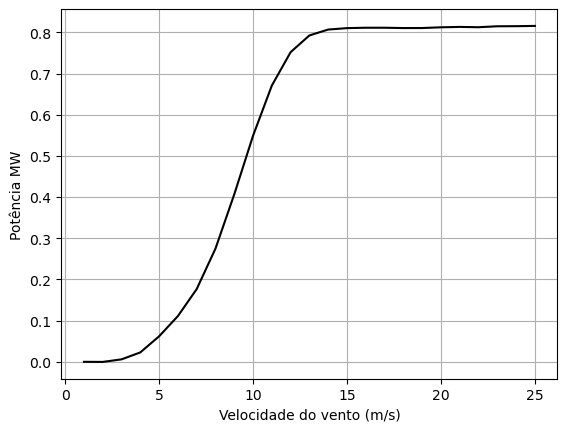

In [49]:
# Se obtem uma função polinómica para a Curva de potencia da turbina
p = [3.96376217e-16, -5.28306514e-14,  2.21657084e-12,  2.95649555e-11,
     -6.90859490e-09,  3.36160875e-07, -9.36759178e-06,  1.72239869e-04,
     -2.18626984e-03,  1.93901064e-02, -1.19402467e-01,  4.99717900e-01,
     -1.36670238e+00,  2.28962093e+00, -2.07987566e+00,  7.59296976e-01]
p_0 = p[0]; p_1 = p[1]; p_2 = p[2]; p_3 = p[3]; p_4 = p[4]; p_5 = p[5]; p_6 = p[6]; p_7 = p[7];p_8 = p[8]; p_9 = p[9]; 
p_10 = p[10]; p_11= p[11]; p_12 = p[12]; p_13 = p[13]; p_14 = p[14]; p_15 = p[15]

f_p=lambda t: p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15

ppp=list(map(f_p, range(1,26)))

xx=list(range(1,26))

plt.plot(xx, ppp, color='black')
plt.xlabel('Velocidade do vento (m/s)')
plt.ylabel('Potência MW')
plt.grid(visible=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AttributeError: 'numpy.ndarray' object has no attribute 'label_outer'

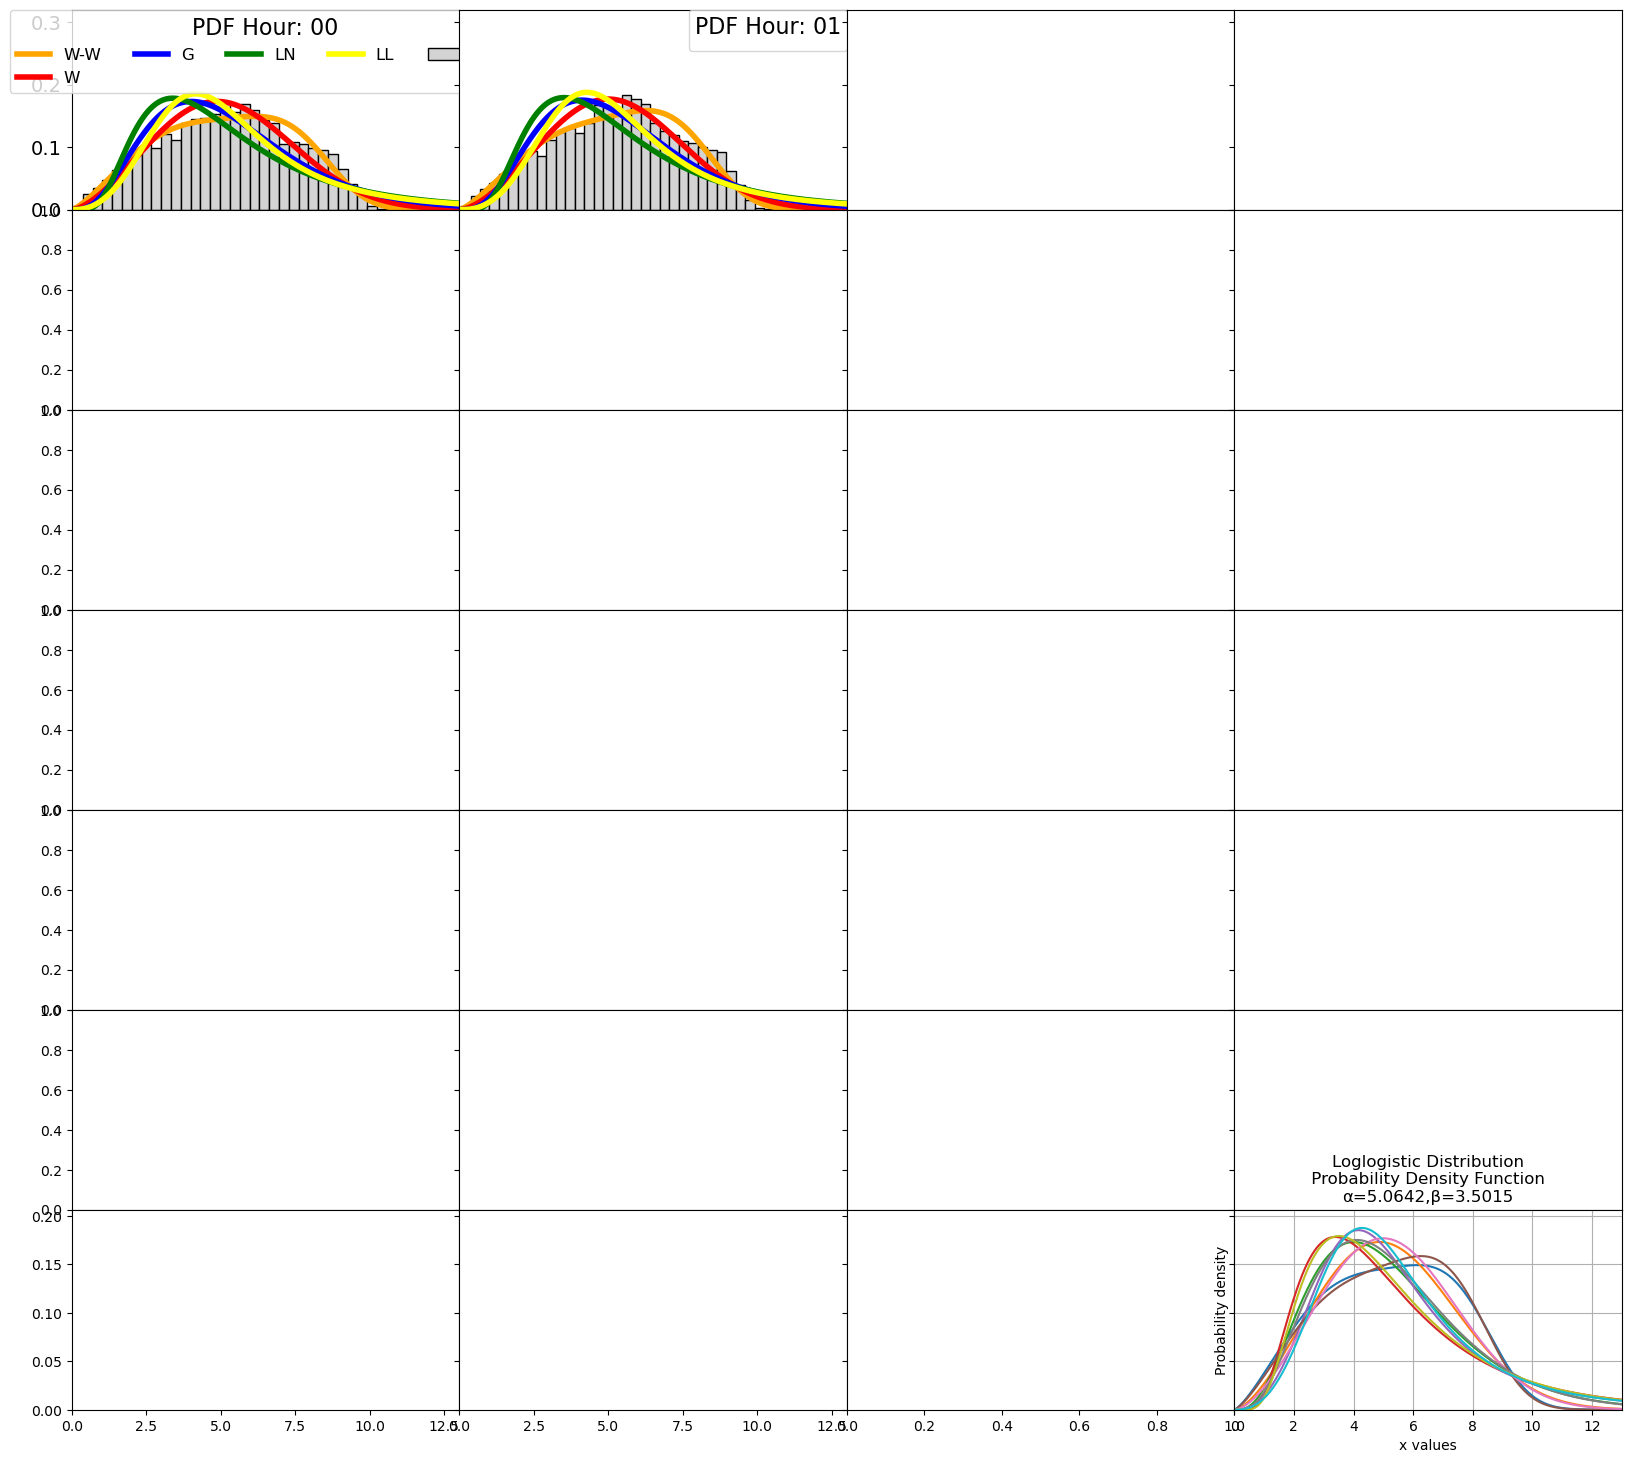

In [65]:
#Cálculo das PDFs horárias para a serie temporal completa utilizando só módulo Reliability

fig, axs = plt.subplots(7, 4, figsize=(20,20), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.0001, hspace=0.0001)
k=-1
x = np.linspace(0, 13, 1000)
line_labels = ["W-W", "W", "G", "LN", "LL", "Data"]

for i in range (1):
    for j in range(2):
        k+=1
        hist_1=axs[i, j].hist(H_ws[k], bins='auto', density=True, color="lightgrey", edgecolor='black')
        axs[i, j].tick_params(axis='both', which='major', labelsize=14)
        #axs[i, j].set_xlabel('Wind Speed [m/s]', size=14)
        #axs[i, j].set_ylabel('Probability', size=14)
        axs[i, j].set_xlim(0, 13)
        axs[i, j].set_ylim(0, 0.32)
       # axs[i, j].set_title(Hour[k], size=15)
        ppp=np.array(list(map(f_p, 0.5*(hist_1[1][1:]+hist_1[1][0:-1])))) 
        P = np.sum(hist_1[0]*ppp*(hist_1[1][1]-hist_1[1][0]))
        dados=H_ws[k]#H_ws.to_numpy())
        dados=np.transpose(dados.tolist()) 
        dados=dados[0]
        
        weibull_mixture_fit = Fit_Weibull_Mixture(failures=dados, method='MLE', show_probability_plot=False, print_results=False,
                                                  optimizer='best')
        a1 = weibull_mixture_fit.alpha_1
        b1 = weibull_mixture_fit.beta_1
        a2 = weibull_mixture_fit.alpha_2
        b2 = weibull_mixture_fit.beta_2
        p1 = weibull_mixture_fit.proportion_1
        p2 = weibull_mixture_fit.proportion_2
        wb1 = Weibull_Distribution(alpha=a1, beta=b1) # generate a weibull distribution 1
        wb2 = Weibull_Distribution(alpha=a2, beta=b2) # generate a weibull distribution 1
        dist = Mixture_Model(distributions=[wb1, wb2], proportions=[p1, p2])
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="orange", linewidth=4)
        for q in range(4):
            table_gof.iat[0,k*4+q] = weibull_mixture_fit.goodness_of_fit.iat[q, 1]
            table_gof_mean.iat[0, q] += weibull_mixture_fit.goodness_of_fit.iat[q, 1]
             
        #W_W = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))
        Inte_PWW = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_WW = integrate.quad(Inte_PWW, 0, 15)
        
        
        weibull_fit = Fit_Weibull_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        a = weibull_fit.alpha
        b = weibull_fit.beta
        dist = Weibull_Distribution(alpha=a, beta=b)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="red", linewidth=4)
        table_gof.iat[0,1]
        for q in range(4):
            table_gof.iat[1,k*4+q] = weibull_fit.goodness_of_fit.iat[q, 1]
            table_gof_mean.iat[1, q] += weibull_fit.goodness_of_fit.iat[q, 1]
        
        #W = lambda t: (b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))
        Inte_PW = lambda t:(b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_W = integrate.quad(Inte_PW, 0, 15)
        
        
        Gamma_fit = Fit_Gamma_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        a = Gamma_fit.alpha
        b = Gamma_fit.beta
        #c = Gamma_fit.gamma
        dist = Gamma_Distribution(alpha=a, beta=b) #, gamma=c)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="blue", linewidth=4)
        for q in range(4):
            table_gof.iat[2,k*4+q] = Gamma_fit.goodness_of_fit.iat[q, 1]
            table_gof_mean.iat[2, q] += Gamma_fit.goodness_of_fit.iat[q, 1]
            
        Inte_R_b = lambda t: t**(b-1)*np.exp(-t) 
        R_b = integrate.quad(Inte_R_b, 0, 100)    
        #G = lambda t: t**(b-1)/(R_b*a**b)*np.exp(-t/a)
        Inte_P_G = lambda t: (t**(b-1)/(R_b[0]*a**b)*np.exp(-t/a))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_G = integrate.quad(Inte_P_G, 0, 15)
        
        
        Lnormal_fit = Fit_Lognormal_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        m = Lnormal_fit.mu
        s = Lnormal_fit.sigma
        dist = Lognormal_Distribution(mu=m, sigma=s)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="green", linewidth=4)
        for q in range(4):
            table_gof.iat[3,k*4+q] = Lnormal_fit.goodness_of_fit.iat[q, 1]
            table_gof_mean.iat[3, q] += Lnormal_fit.goodness_of_fit.iat[q, 1]
            
        #L = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))
        Inte_PL = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_L = integrate.quad(Inte_PL, 0, 15)
        
        
        Llogist_fit = Fit_Loglogistic_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        a = Llogist_fit.alpha
        b = Llogist_fit.beta
        dist = Loglogistic_Distribution(alpha=a, beta=b)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="yellow", linewidth=4)
        for q in range(4):
            table_gof.iat[4,k*4+q] = Llogist_fit.goodness_of_fit.iat[q, 1]
            table_gof_mean.iat[4, q] += Llogist_fit.goodness_of_fit.iat[q, 1]
            
        #LL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)
        Inte_PLL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_LL = integrate.quad(Inte_PLL, 0, 15)
        
        title_h = 'PDF ' + str(Hour[k])
        
        if i==0and j==0:
            axs[0, 0].legend(labels=line_labels, 
                               loc="upper center",
                               ncol=5,
                               borderaxespad=0,    
                               title=title_h,      
                               fontsize= 12,
                               title_fontsize = 16
                               )
        else:
            axs[i, j].legend(        # The line objects           
            #   labels=line_labels,   # The labels for each line
               loc="upper right",    # Position of legend
               borderaxespad=0,    # Small spacing around legend box
               title=title_h,          # Title for the legend
            #   fontsize= 16,
               title_fontsize = 16
            )
        
        plt.grid(visible=True)
        
        
        
        table4['Data Pot'][k] = P
        table4['TC-Weibull Pot'][k] = P_WW[0]
        table4['Weibull Pot'][k] = P_W[0] 
        table4['Gamma Pot'][k] = P_G[0]
        table4['Log-Normal Pot'][k] = P_L[0]
        table4['Log-Logistic Pot'][k] = P_LL[0]
    
        table4['TC-Weibull Diff'][k] = P-P_WW[0]
        table4['Weibull Diff'][k] = P-P_W[0]
        table4['Gamma Diff'][k] = P-P_G[0]
        table4['Log-Normal Diff'][k] = P-P_L[0]
        table4['Log-Logistic Diff'][k] = P-P_LL[0]
        


for ax in axs:
    ax.label_outer()        
        
for i in range(5): #for da PDF
    for q in range(4): #for da quallidade do ajuste
        table_gof_mean.iat[i, q] = table_gof_mean.iat[i, q]/24          
        
                
#dist.PDF(x)       
fig.tight_layout()
#plt.savefig("PDFs of each Hour_artigo")

In [24]:
dir(weibull_mixture_fit.distribution)

NameError: name 'weibull_mixture_fit' is not defined

In [50]:
table_gof.to_excel("goodness_of_fit_hour_Fortim.xls")

table_gof_mean.to_excel("mean_goodness_of_fit_hour_Fortim.xls")

table4.to_excel("Power_hour_Fortim.xls")

In [51]:
table4 #para potência média horária

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

table4.style.set_caption('$Hourly Power$').set_table_styles(styles)# permite apresentar um título na tabela

,Data Pot,TC-Weibull Pot,Weibull Pot,Gamma Pot,Log-Normal Pot,Log-Logistic Pot,TC-Weibull Diff,Weibull Diff,Gamma Diff,Log-Normal Diff,Log-Logistic Diff
Hour,,,,,,,,,,,
00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
#Cria a tabela (formato dataframe) de comparação entre as diferentes PDFs mensais
_table_gof=pd.DataFrame()

_table_gof['PDF'] = ["W-W", "W", "G", "LN", "LL" ]
_table_gof.set_index(['PDF'], inplace=True)

_table_gof['LogL 01']=0.00
_table_gof['AICc 01']=0.00
_table_gof['BIC 01']=0.00 
_table_gof['AD 01']=0.00

_table_gof['LogL 02']=0.00
_table_gof['AICc 02']=0.00
_table_gof['BIC 02']=0.00 
_table_gof['AD 02']=0.00

_table_gof['LogL 03']=0.00
_table_gof['AICc 03']=0.00
_table_gof['BIC 03']=0.00 
_table_gof['AD 03']=0.00

_table_gof['Log 04']=0.00
_table_gof['AICc 04']=0.00
_table_gof['BIC 04']=0.00 
_table_gof['AD 04']=0.00

_table_gof['LogL 05']=0.00
_table_gof['AICc 05']=0.00
_table_gof['BIC 05']=0.00 
_table_gof['AD 05']=0.00

_table_gof['LogL 06']=0.00
_table_gof['AICc 06']=0.00
_table_gof['BIC 06']=0.00 
_table_gof['AD 06']=0.00

_table_gof['LogL 07']=0.00
_table_gof['AICc 07']=0.00
_table_gof['BIC 07']=0.00 
_table_gof['AD 07']=0.00

_table_gof['LogL 08']=0.00
_table_gof['AICc 08']=0.00
_table_gof['BIC 08']=0.00 
_table_gof['AD 08']=0.00

_table_gof['LogL 09']=0.00
_table_gof['AICc 09']=0.00
_table_gof['BIC 09']=0.00 
_table_gof['AD 09']=0.00

_table_gof['LogL 10']=0.00
_table_gof['AICc 10']=0.00
_table_gof['BIC 10']=0.00 
_table_gof['AD 10']=0.00

_table_gof['LogL 11']=0.00
_table_gof['AICc 11']=0.00
_table_gof['BIC 11']=0.00 
_table_gof['AD 11']=0.00

_table_gof['LogL 12']=0.00
_table_gof['AICc 12']=0.00
_table_gof['BIC 12']=0.00 
_table_gof['AD 12']=0.00

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

_table_gof.style.set_caption('$goodness$ $of$ $fit$').set_table_styles(styles)# permite apresentar um título na tabela

,LogL 01,AICc 01,BIC 01,AD 01,LogL 02,AICc 02,BIC 02,AD 02,LogL 03,AICc 03,BIC 03,AD 03,Log 04,AICc 04,BIC 04,AD 04,LogL 05,AICc 05,BIC 05,AD 05,LogL 06,AICc 06,BIC 06,AD 06,LogL 07,AICc 07,BIC 07,AD 07,LogL 08,AICc 08,BIC 08,AD 08,LogL 09,AICc 09,BIC 09,AD 09,LogL 10,AICc 10,BIC 10,AD 10,LogL 11,AICc 11,BIC 11,AD 11,LogL 12,AICc 12,BIC 12,AD 12
PDF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
W-W,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
W,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
# Tabela qualidade do ajuste mensal
_table_gof_mean=pd.DataFrame()
_
_table_gof_mean['PDF'] = ["W-W", "W", "G", "LN", "LL" ]
_table_gof_mean.set_index(['PDF'], inplace=True)
_
_table_gof_mean['LogL'] = 0.00
_table_gof_mean['AICc'] = 0.00
_table_gof_mean['BIC']  = 0.00 
_table_gof_mean['AD']   = 0.00
_table_gof_mean

,LogL,AICc,BIC,AD
PDF,,,,
W-W,0,0,0,0
W,0,0,0,0
G,0,0,0,0
LN,0,0,0,0
LL,0,0,0,0


In [54]:
#Cria a tabela (formato dataframe) de comparação entre as diferentes PDFs mensais
table5=pd.DataFrame()

table5['Month'] = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'Setember', 'October', 'November', 'December']
table5['Data Pot']=0.00
table5['TC-Weibull Pot']=0.00 
table5['Weibull Pot']=0.00
table5['Gamma Pot']=0.00
table5['Log-Normal Pot']=0.00
table5['Log-Logistic Pot']=0.00

table5['TC-Weibull Diff']=0.00 
table5['Weibull Diff']=0.00
table5['Gamma Diff']=0.00
table5['Log-Normal Diff']=0.00
table5['Log-Logistic Diff']=0.00
table5.set_index(['Month'], inplace=True)

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

table5.style.set_caption('$Wind$ $Power$ $Density$ $[W/m^2]$').set_table_styles(styles)# permite apresentar um título na tabela
table5

,Data Pot,TC-Weibull Pot,Weibull Pot,Gamma Pot,...,Weibull Diff,Gamma Diff,Log-Normal Diff,Log-Logistic Diff
Month,,,,,,,,,
January,0,0,0,0,...,0,0,0,0
February,0,0,0,0,...,0,0,0,0
March,0,0,0,0,...,0,0,0,0
April,0,0,0,0,...,0,0,0,0
May,0,0,0,0,...,0,0,0,0
June,0,0,0,0,...,0,0,0,0
July,0,0,0,0,...,0,0,0,0
August,0,0,0,0,...,0,0,0,0
Setember,0,0,0,0,...,0,0,0,0


In [55]:
M_ws = [ws_meanxhora.loc[(ws_meanxhora.index.get_level_values(level='Year')>=2001) &
                        (ws_meanxhora.index.get_level_values(level='Year')<=2022) & 
                        (ws_meanxhora.index.get_level_values(level='Month')==j+1)].to_numpy() for j in range(12)]
    
MES=['January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'Setember', 'October', 'November', 'December']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

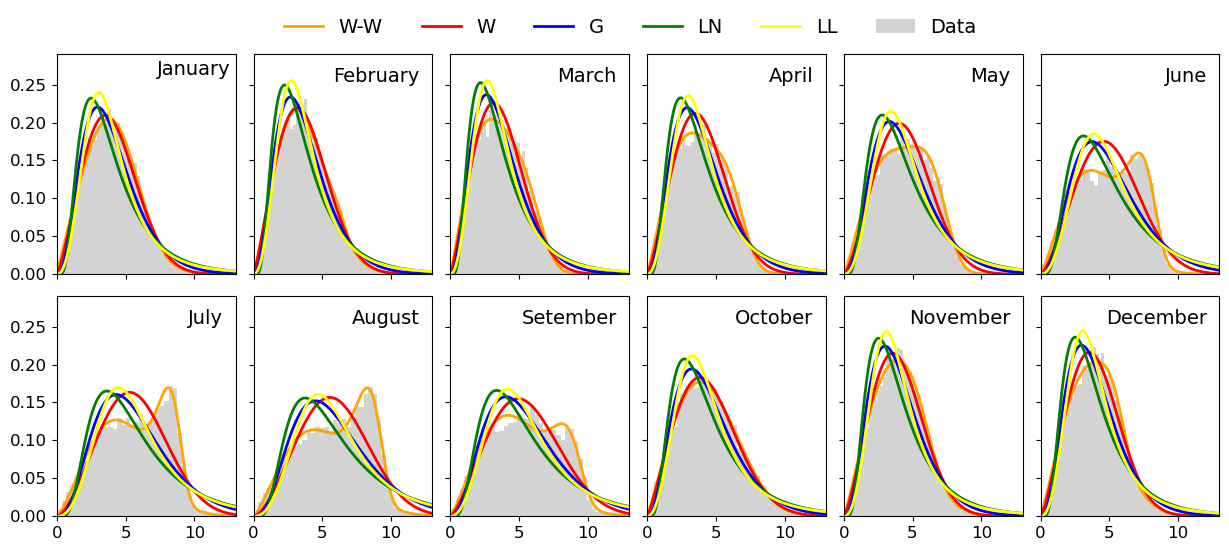

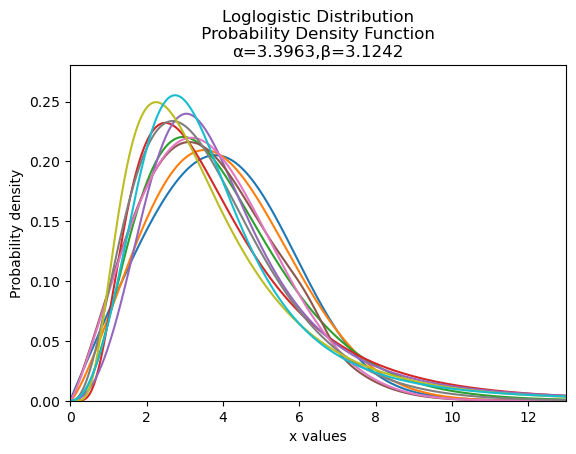

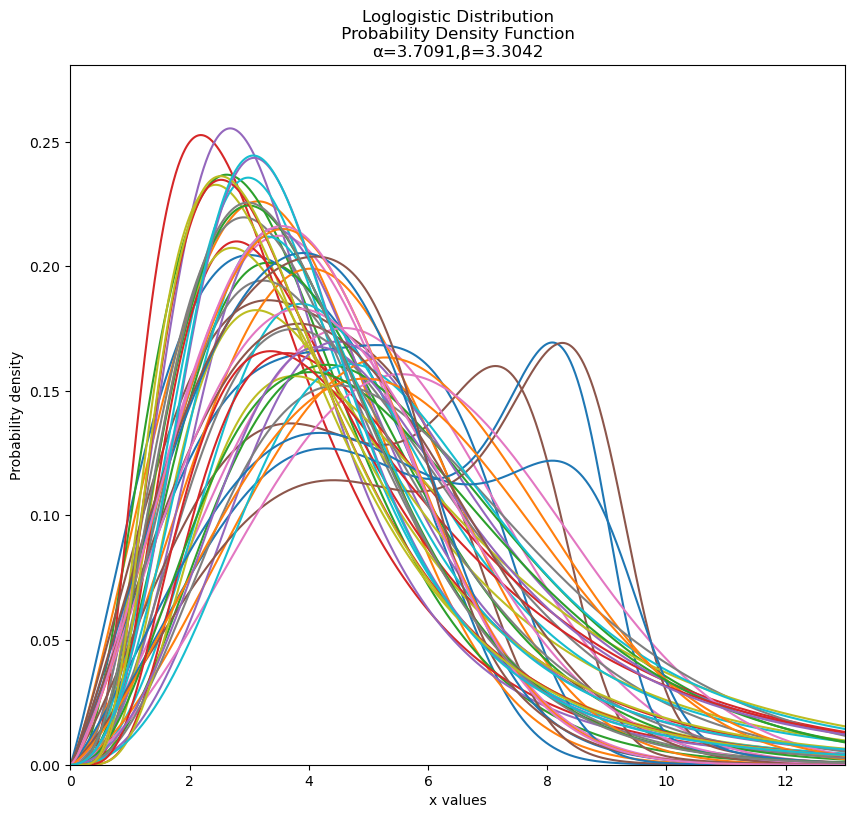

In [56]:
#Cálculo das distribuições mensais para a serie temporal completa

fig, axs = plt.subplots(2, 6, figsize=(15,6), sharex='col', sharey='row')
fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.figure(2)
#axs.label_outer()
k=-1
x = np.linspace(0, 13, 1000)
line_labels = ["W-W", "W", "G", "LN", "LL", "Data"]

weibull_mix = [ [] for i in range(12)]
weibull     = [ [] for i in range(12)]
Gamma       = [ [] for i in range(12)]
Lnormal   =   [ [] for i in range(12)]
Llogist     = [ [] for i in range(12)]

for i in range (2):
    for j in range(6):
        k+=1
        hist_1=axs[i, j].hist(M_ws[k], bins='auto', density=True, color="lightgrey")#, edgecolor='withe')
        axs[i, j].tick_params(axis='both', which='major', labelsize=12)
       # axs[i, j].set_xlabel('Wind Speed [m/s]', size=12)
       # axs[i, j].set_ylabel('Probability', size=12)
        axs[i, j].set_xlim(0, 13)
        axs[i, j].set_ylim(0, 0.29)
        axs[i, j].label_outer()
       # axs[i, j].set_title(Hour[k], size=15)
        ppp=np.array(list(map(f_p, 0.5*(hist_1[1][1:]+hist_1[1][0:-1])))) 
        P = np.sum(hist_1[0]*ppp*(hist_1[1][1]-hist_1[1][0]))
        dados=M_ws[k]#M_ws.to_numpy())
        dados=np.transpose(dados.tolist()) 
        dados=dados[0]
        
        weibull_mix[k] = Fit_Weibull_Mixture(failures=dados, method='MLE', show_probability_plot=False, print_results=False,
                                                  optimizer='best')
        a1 = weibull_mix[k].alpha_1
        b1 = weibull_mix[k].beta_1
        a2 = weibull_mix[k].alpha_2
        b2 = weibull_mix[k].beta_2
        p1 = weibull_mix[k].proportion_1
        p2 = weibull_mix[k].proportion_2
        wb1 = Weibull_Distribution(alpha=a1, beta=b1) # generate a weibull distribution 1
        wb2 = Weibull_Distribution(alpha=a2, beta=b2) # generate a weibull distribution 1
        dist = Mixture_Model(distributions=[wb1, wb2], proportions=[p1, p2])
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="orange", linewidth=2)
        for q in range(4):
            _table_gof.iat[0,k*4+q] = weibull_mix[k].goodness_of_fit.iat[q, 1]
            _table_gof_mean.iat[0, q] += weibull_mix[k].goodness_of_fit.iat[q, 1]
             
        #W_W = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))
        Inte_PWW = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_WW = integrate.quad(Inte_PWW, 0, 15)
        
        
        weibull[k] = Fit_Weibull_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        a = weibull[k].alpha
        b = weibull[k].beta
        dist = Weibull_Distribution(alpha=a, beta=b)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="red", linewidth=2)
        table_gof.iat[0,1]
        for q in range(4):
            _table_gof.iat[1,k*4+q] = weibull[k].goodness_of_fit.iat[q, 1]
            _table_gof_mean.iat[1, q] += weibull[k].goodness_of_fit.iat[q, 1]
        
        #W = lambda t: (b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))
        Inte_PW = lambda t:(b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_W = integrate.quad(Inte_PW, 0, 15)
        
        
        Gamma[k]= Fit_Gamma_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        a = Gamma[k].alpha
        b = Gamma[k].beta
        #c = Gamma_fit.gamma
        dist = Gamma_Distribution(alpha=a, beta=b) #, gamma=c)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="blue", linewidth=2)
        for q in range(4):
            _table_gof.iat[2,k*4+q] = Gamma[k].goodness_of_fit.iat[q, 1]
            _table_gof_mean.iat[2, q] += Gamma[k].goodness_of_fit.iat[q, 1]
            
        Inte_R_b = lambda t: t**(b-1) * np.exp(-t) 
        R_b = integrate.quad(Inte_R_b, 0, 100)
        R_b = R_b[0]
        #G = lambda t: t**(b-1)/(R_b*a**b)*np.exp(-t/a)
        Inte_P_G = lambda t: (t**(b-1)/(R_b*a**b)*np.exp(-t/a))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_G = integrate.quad(Inte_P_G, 0, 15)
        
        
        Lnormal[k] = Fit_Lognormal_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        m = Lnormal[k].mu
        s = Lnormal[k].sigma
        dist = Lognormal_Distribution(mu=m, sigma=s)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="green", linewidth=2)
        for q in range(4):
            _table_gof.iat[3,k*4+q] = Lnormal[k].goodness_of_fit.iat[q, 1]
            _table_gof_mean.iat[3, q] += Lnormal[k].goodness_of_fit.iat[q, 1]
            
        #L = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))
        Inte_PL = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_L = integrate.quad(Inte_PL, 0, 15)
        
        
        Llogist[k] = Fit_Loglogistic_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
        a = Llogist[k].alpha
        b = Llogist[k].beta
        dist = Loglogistic_Distribution(alpha=a, beta=b)
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="yellow", linewidth=2)
        for q in range(4):
            _table_gof.iat[4,k*4+q] = Llogist[k].goodness_of_fit.iat[q, 1]
            _table_gof_mean.iat[4, q] += Llogist[k].goodness_of_fit.iat[q, 1]
            
        #LL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)
        Inte_PLL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_LL = integrate.quad(Inte_PLL, 0, 15)
        
        #title_m = 'PDFs ' + str(MES[k])
        title_m =  str(MES[k])
        
        if i==0 and j==0:
            fig.legend( labels=line_labels, fontsize= 14, ncol = 6, frameon = False, edgecolor='white',
                       bbox_to_anchor=(0.75, 0.97))
            axs[0, 0].legend(  #labels=line_labels, 
                               loc="upper right",
                               frameon = False,
                               edgecolor='white',
                               borderaxespad=0,    
                               title=title_m,      
                               #fontsize= 10,
                               title_fontsize = 14
                               )
        else:
            axs[i, j].legend(                 
                               #labels=line_labels,   # The labels for each line
                               loc="upper right",    # Position of legend
                               frameon = False,
                               edgecolor='white',
                               #borderaxespad=0.1,    # Small spacing around legend box
                               title=title_m,          # Title for the legend
                               #fontsize= 8,
                               title_fontsize = 14 
                               )
        
        
        fig.subplots_adjust(wspace=0.1, hspace=0.1)
        #axs[i, j].grid()
        
        table5['Data Pot'][k] = P
        table5['TC-Weibull Pot'][k] = P_WW[0]
        table5['Weibull Pot'][k] = P_W[0] 
        table5['Gamma Pot'][k] = P_G[0]
        table5['Log-Normal Pot'][k] = P_L[0]
        table5['Log-Logistic Pot'][k] = P_LL[0]
    
        table5['TC-Weibull Diff'][k] = P-P_WW[0]
        table5['Weibull Diff'][k] = P-P_W[0]
        table5['Gamma Diff'][k] = P-P_G[0]
        table5['Log-Normal Diff'][k] = P-P_L[0]
        table5['Log-Logistic Diff'][k] = P-P_LL[0]
        
        if i==0 and j==1:
            #plt.subplots_adjust(wspace=0.001, hspace=0.001)
            fig1, axs1 = plt.subplots(1, 1, figsize=(10,10))
        
        
for i in range(5): #for da PDF
    for q in range(4): #for da quallidade do ajuste
        _table_gof_mean.iat[i, q] = _table_gof_mean.iat[i, q]/12          
                           
            
#dist.PDF(x)       
#fig.tight_layout()
fig.savefig("PDFs of each month_AP_GO_artigo.png", dpi=600)

In [57]:
fig.savefig("PDFs of each month_AP_GO_artigo.png")

In [60]:
weibull_mix[0].results

TypeError: 'Fit_Weibull_Mixture' object is not subscriptable

In [61]:
table5

,Data Pot,TC-Weibull Pot,Weibull Pot,Gamma Pot,...,Weibull Diff,Gamma Diff,Log-Normal Diff,Log-Logistic Diff
Month,,,,,,,,,
January,0.0543039,0.0545195,0.0536079,0.0585752,...,0.000696,-0.00427128,-0.0155457,-0.0156525
February,0.0450478,0.0442993,0.0442302,0.0477174,...,0.000817632,-0.00266962,-0.013504,-0.0141215
March,0.0417958,0.0416944,0.0410694,0.0456756,...,0.000726384,-0.00387981,-0.0150545,-0.0167828
April,0.0524093,0.0524228,0.0519922,0.0583806,...,0.000417131,-0.00597127,-0.0169439,-0.0188645
May,0.0702736,0.0699142,0.0695258,0.0782186,...,0.000747881,-0.00794493,-0.0183103,-0.020069
June,0.105695,0.1051,0.104593,0.113196,...,0.00110143,-0.0075009,-0.0117823,-0.0157631
July,0.146259,0.145504,0.142578,0.147632,...,0.00368067,-0.001373,0.000519839,-0.0060144
August,0.168073,0.167318,0.162203,0.164329,...,0.00586945,0.00374358,0.00996508,0.000617119
Setember,0.14512,0.144346,0.140392,0.142015,...,0.00472864,0.00310508,0.00684977,0.00189105


In [62]:
_table_gof.to_excel("goodness_of_fit_month_Ap.xls")

_table_gof_mean.to_excel("mean_goodness_of_fit_month_Ap.xls")

table5.to_excel("Power_month_Ap.xls")

In [63]:
ws_meanxhora

Wind Speed
Year Month Day Hour            
2000 12    31  21          1.79
               22          1.64
               23           1.3
2001 1     1   0           0.82
               1           1.25
...                         ...
2022 3     31  16          1.68
               17          1.33
               18          1.02
               19          0.89
               20           1.2

[186240 rows x 1 columns]

In [64]:
table_E = [[i] for i in range(20)]
table_E [0:3]

[[0], [1], [2]]

In [65]:
table_E = [pd.DataFrame() for i in range(20)]

In [66]:
#Cria a tabela de Energia (formato dataframe) de comparação entre as diferentes distribuições
table_E = [pd.DataFrame() for i in range(20)]
for i in range(20):
    table_E[i]['Month'] = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'Setember', 'October', 'November', 'December']
    table_E[i]['Data E']=0.00
    table_E[i]['TC-Weibull E']=0.00 
    table_E[i]['Weibull E']=0.00
    table_E[i]['Gamma E']=0.00
    table_E[i]['Log-Nor E']=0.00
    table_E[i]['Log-Log E']=0.00
    
    table_E[i]['TC-Weibull Diff']=0.00 
    table_E[i]['Weibull Diff']=0.00
    table_E[i]['Gamma Diff']=0.00
    table_E[i]['Log-Nor Diff']=0.00
    table_E[i]['Log-Log Diff']=0.00
    table_E[i].set_index(['Month'], inplace=True)

    styles = [dict(selector="Caption",
                   props=[("text-align", "center"),
                          ("font-size", "100%"),
                          ("color", 'black')])]
    
    table_E[i].style.set_caption('$Wind$ $Power$ $Density$ $[W/m^2]$').set_table_styles(styles)# permite apresentar um título na tabela
table_E[2]

,Data E,TC-Weibull E,Weibull E,Gamma E,...,Weibull Diff,Gamma Diff,Log-Nor Diff,Log-Log Diff
Month,,,,,,,,,
January,0,0,0,0,...,0,0,0,0
February,0,0,0,0,...,0,0,0,0
March,0,0,0,0,...,0,0,0,0
April,0,0,0,0,...,0,0,0,0
May,0,0,0,0,...,0,0,0,0
June,0,0,0,0,...,0,0,0,0
July,0,0,0,0,...,0,0,0,0
August,0,0,0,0,...,0,0,0,0
Setember,0,0,0,0,...,0,0,0,0


In [70]:
#exemplo
month_2021 = [ws_meanxhora.loc[(ws_meanxhora.index.get_level_values(level='Year')==2021) &

                               (ws_meanxhora.index.get_level_values(level='Month')==j+1)].to_numpy() for j in range(12)]

In [71]:
#exemplo
rmse = np.zeros((5,20))

In [72]:
#comparação Energia de cada mês de cada ano 

d_year = [[] for i in range(20)]
rmse = np.zeros((5,20))
#x = np.linspace(0, 13, 1000)
rmse_WW = rmse_W = rmse_G = rmse_LN = rmse_LL = 0
mae_WW = mae_W = mae_G = mae_LN = mae_LL = 0
mape_WW = mape_W = mape_G = mape_LN = mape_LL = 0

nn=0

for i in range (20):
    d_year[i] = [ws_meanxhora.loc[(ws_meanxhora.index.get_level_values(level='Year')==(2002+i)) &
                (ws_meanxhora.index.get_level_values(level='Month')==(j+1))].to_numpy() for j in range(12)]
    for k in range(12): 
    
        hist_1 = plt.hist(d_year[i][k], bins='auto', density=True, color="lightgrey", edgecolor='black')
        plt.close()
      
        ppp = np.array(list(map(f_p, 0.5*(hist_1[1][1:]+hist_1[1][0:-1])))) 
        P   = np.sum(hist_1[0]*ppp*(hist_1[1][1]-hist_1[1][0]))
        
        #W-W
        a1 = weibull_mix[k].alpha_1
        b1 = weibull_mix[k].beta_1
        a2 = weibull_mix[k].alpha_2
        b2 = weibull_mix[k].beta_2
        p1 = weibull_mix[k].proportion_1
        p2 = weibull_mix[k].proportion_2
        
        Inte_PWW = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_WW = integrate.quad(Inte_PWW, 0, 15)
        
        #W
        a = weibull[k].alpha
        b = weibull[k].beta
        Inte_PW = lambda t:(b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_W = integrate.quad(Inte_PW, 0, 15)
        
        
        #Gamma
        a = Gamma[k].alpha
        b = Gamma[k].beta
        c = Gamma[k].gamma
        Inte_R_b = lambda t: t**(b-1) * np.exp(-t) 
        R_b = integrate.quad(Inte_R_b, 0, 100)
        R_b = R_b[0]
        Inte_P_G = lambda t: (t**(b-1)/(R_b*a**b)*np.exp(-t/a))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_G = integrate.quad(Inte_P_G, 0, 15)
        
        #LN 
        m = Lnormal[k].mu
        s = Lnormal[k].sigma
       
        Inte_PL = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_LN = integrate.quad(Inte_PL, 0, 15)
        
        #LL
        a = Llogist[k].alpha
        b = Llogist[k].beta
        Inte_PLL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
        P_LL = integrate.quad(Inte_PLL, 0, 15)
        
        qt_hour = len(d_year[i][k])
        E       = P*qt_hour
        E_WW    = P_WW[0]*qt_hour
        E_W     = P_W[0]*qt_hour 
        E_G     = P_G[0]*qt_hour 
        E_LN    = P_LN[0]*qt_hour 
        E_LL    = P_LL[0]*qt_hour 
        
        table_E[i]['Data E'][k]           = E    
        table_E[i]['TC-Weibull E'][k]     = E_WW
        table_E[i]['Weibull E'][k]        = E_W  
        table_E[i]['Gamma E'][k]          = E_G
        table_E[i]['Log-Nor E'][k]        = E_LN
        table_E[i]['Log-Log E'][k]        = E_LL
    
        table_E[i]['TC-Weibull Diff'][k]  = er_WW = E_WW - E
        table_E[i]['Weibull Diff'][k]     = er_W  = E_W  - E
        table_E[i]['Gamma Diff'][k]       = er_G  = E_G  - E
        table_E[i]['Log-Nor Diff'][k]     = er_LN = E_LN - E
        table_E[i]['Log-Log Diff'][k]     = er_LL = E_LL - E
        
        rmse_WW += er_WW**2
        rmse_W  += er_W **2  
        rmse_G  += er_G **2
        rmse_LN += er_LN**2
        rmse_LL += er_LL**2
        
        nn += 1
        #rmse_WW += rmse[0][i] 
        #rmse_W  += rmse[1][i]
        #rmse_G  += rmse[2][i]
        #rmse_LN += rmse[3][i]
        #rmse_LL += rmse[4][i]  
        
        mae_WW  += abs(er_WW)
        mae_W   += abs(er_W )
        mae_G   += abs(er_G )
        mae_LN  += abs(er_LN)
        mae_LL  += abs(er_LL)
            
        mape_WW += abs(er_WW)/E
        mape_W  += abs(er_W )/E
        mape_G  += abs(er_G )/E
        mape_LN += abs(er_LN)/E
        mape_LL += abs(er_LL)/E
    
    #rmse[0][i] = (rmse[0][i]) #/12)**0.5
    #rmse[1][i] = (rmse[1][i]) #/12)**0.5
    #rmse[2][i] = (rmse[2][i]) #/12)**0.5
    #rmse[3][i] = (rmse[3][i]) #/12)**0.5
    #rmse[4][i] = (rmse[4][i]) #/12)**0.5
    
    rmse_WW = (rmse_WW/nn)**0.5
    rmse_W  = (rmse_W /nn)**0.5
    rmse_G  = (rmse_G /nn)**0.5
    rmse_LN = (rmse_LN/nn)**0.5
    rmse_LL = (rmse_LL/nn)**0.5
    
    mae_WW  = mae_WW/nn
    mae_W   = mae_W /nn
    mae_G   = mae_G /nn
    mae_LN  = mae_LN/nn
    mae_LL  = mae_LL/nn
    
    mape_WW  = 100*mape_WW/nn
    mape_W   = 100*mape_W /nn
    mape_G   = 100*mape_G /nn
    mape_LN  = 100*mape_LN/nn
    mape_LL  = 100*mape_LL/nn

TypeError: 'Fit_Weibull_Mixture' object is not subscriptable

In [73]:
print (rmse_WW, rmse_W, rmse_G, rmse_LN, rmse_LL)
print (mae_WW, mae_W, mae_G, mae_LN, mae_LL)
print (mape_WW, mape_W, mape_G, mape_LN, mape_LL)

0 0 0 0 0
0 0 0 0 0
0 0 0 0 0


In [74]:
table_E[19].to_excel('Energy_mensal_Ano2021_Ap.xls')


In [75]:
print(sum(rmse.transpose()[:,0]), sum(rmse.transpose()[:,1]), sum(rmse.transpose()[:,2]))

0.0 0.0 0.0


In [76]:
#Cria a tabela (formato dataframe) de comparação entre as diferentes distribuições
A_table_gof=pd.DataFrame()

A_table_gof['PDF'] = ["W-W", "W", "G", "LN", "LL" ]
A_table_gof.set_index(['PDF'], inplace=True)

A_table_gof['LogL']=0.00
A_table_gof['AICc']=0.00
A_table_gof['BIC'] =0.00 
A_table_gof['AD']  =0.00

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

A_table_gof.style.set_caption('$goodness$ $of$ $fit$').set_table_styles(styles)# permite apresentar um título na tabela


A_table_gof_mean=pd.DataFrame()
A_table_gof_mean['PDF'] = ["W-W", "W", "G", "LN", "LL" ]
A_table_gof_mean.set_index(['PDF'], inplace=True)

A_table_gof_mean['LogL'] = 0.00
A_table_gof_mean['AICc'] = 0.00
A_table_gof_mean['BIC']  = 0.00 
A_table_gof_mean['AD']   = 0.00


#Cria a tabela (formato dataframe) de comparação entre as diferentes distribuições
table6=pd.DataFrame()

table6['Year'] = ['2002 to 2021']#'January', 'February', 'March', 'April', 'May', 'June',
#                   'July', 'August', 'Setember', 'October', 'November', 'December']
table6['Data Pot']=0.00
table6['TC-Weibull Pot']=0.00 
table6['Weibull Pot']=0.00
table6['Gamma Pot']=0.00
table6['Log-Normal Pot']=0.00
table6['Log-Logistic Pot']=0.00

table6['TC-Weibull Diff']=0.00 
table6['Weibull Diff']=0.00
table6['Gamma Diff']=0.00
table6['Log-Normal Diff']=0.00
table6['Log-Logistic Diff']=0.00
table6.set_index(['Year'], inplace=True)

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

table6.style.set_caption('$Wind$ $Power$ $Density$ $[W/m^2]$').set_table_styles(styles)# permite apresentar um título na tabela

,Data Pot,TC-Weibull Pot,Weibull Pot,Gamma Pot,Log-Normal Pot,Log-Logistic Pot,TC-Weibull Diff,Weibull Diff,Gamma Diff,Log-Normal Diff,Log-Logistic Diff
Year,,,,,,,,,,,
2002 to 2021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [77]:
A_table_gof

,LogL,AICc,BIC,AD
PDF,,,,
W-W,0,0,0,0
W,0,0,0,0
G,0,0,0,0
LN,0,0,0,0
LL,0,0,0,0


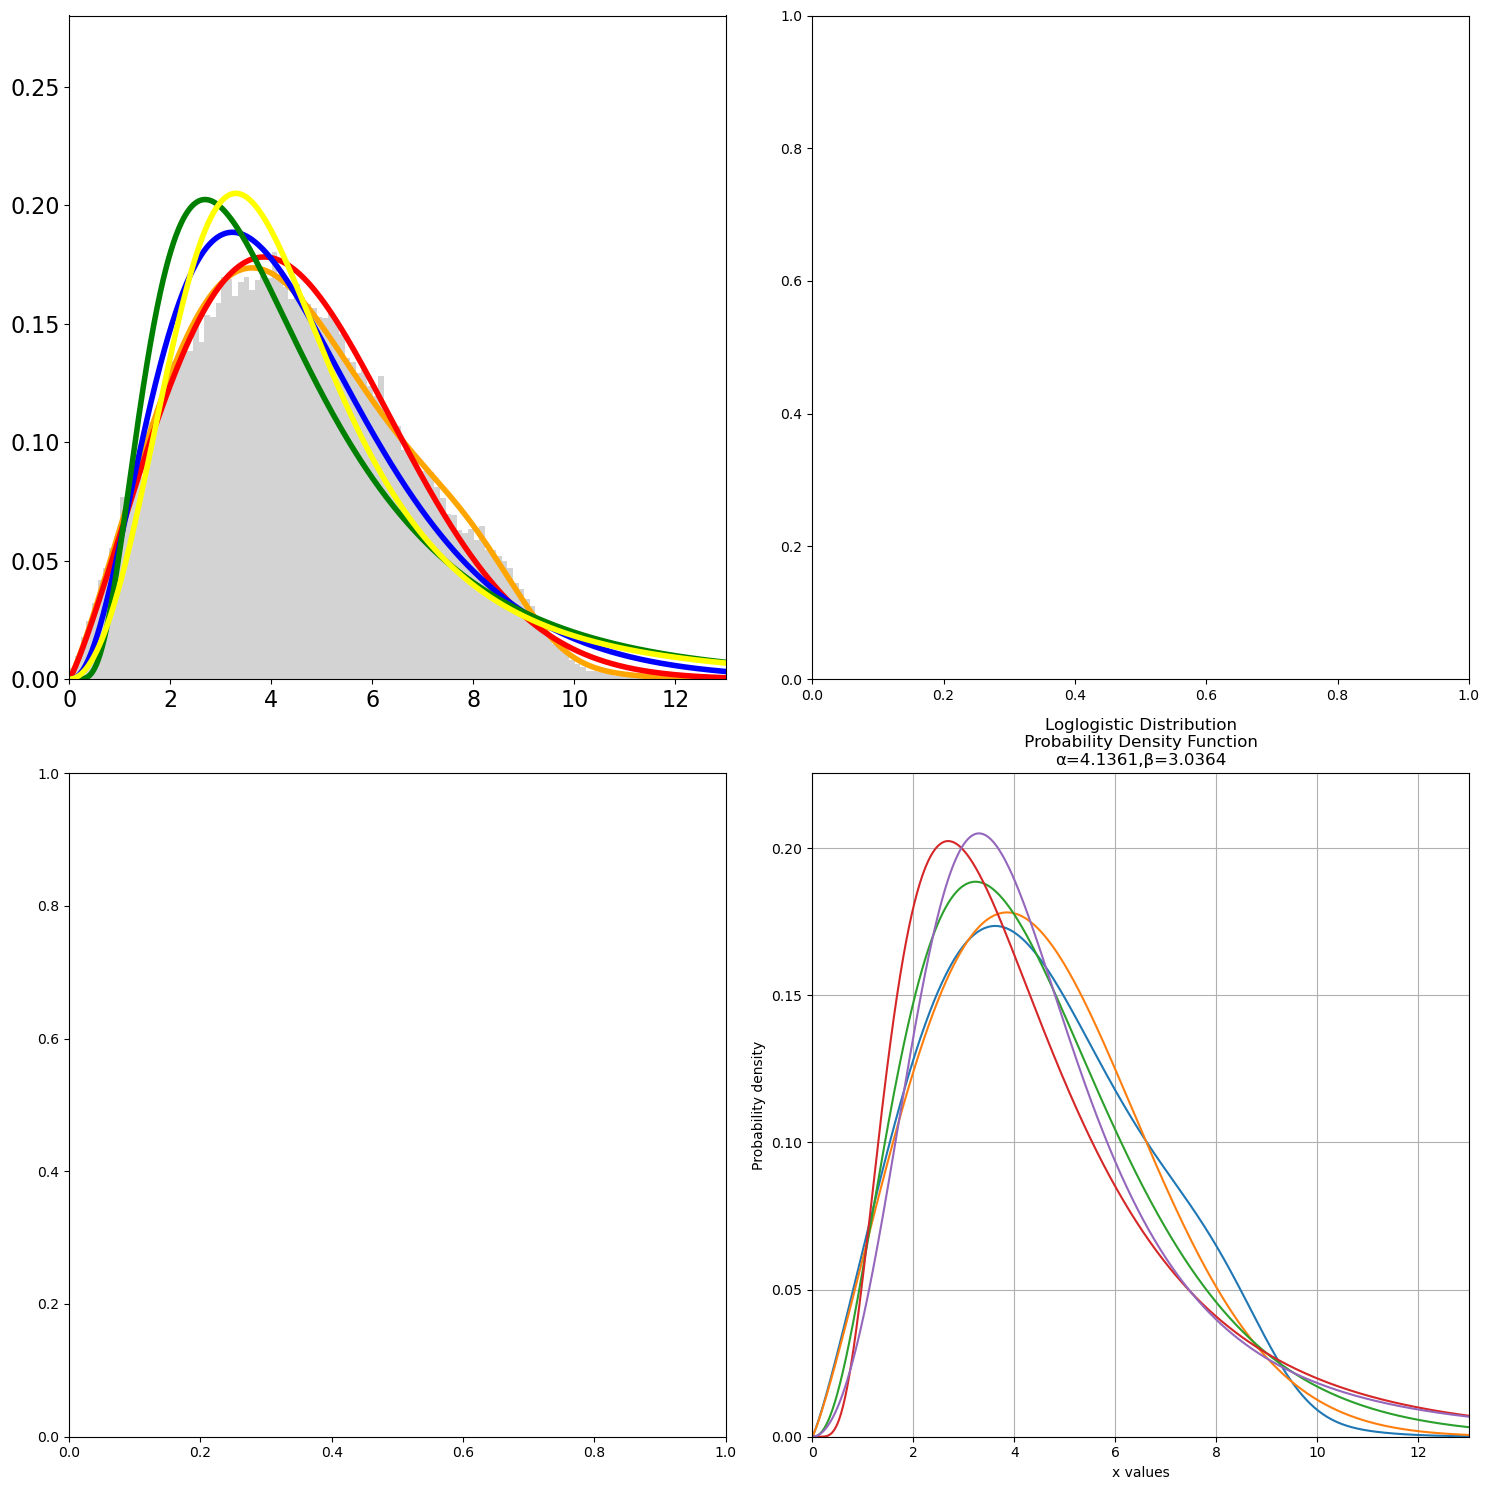

In [79]:
#comparação de E de cada ano

A_ws = ws_meanxhora.to_numpy()
    
#MES=['January', 'February', 'March', 'April', 'May', 'June',
#    'July', 'August', 'Setember', 'October', 'November', 'December']

fig, axs = plt.subplots(2, 2, figsize=(15,15))
k=-1
x = np.linspace(0, 13, 1000)
line_labels = ["W-W", "W", "G", "LN", "LL", "Data",]

#weibull_mix = [ [] for i in range(12)]
#weibull     = [ [] for i in range(12)]
#Gamma       = [ [] for i in range(12)]
#Lnormal   =   [ [] for i in range(12)]
#Llogist     = [ [] for i in range(12)]
#
#for i in range (4):
#    for j in range(3):
   #     k+=1
    
hist_1=axs[0,0].hist(A_ws, bins='auto', density=True, color="lightgrey")#, edgecolor='black')
axs[0,0].tick_params(axis='both', which='major', labelsize=16)
axs[0,0].set_xlim(0,13)
axs[0,0].set_ylim(0,0.28)

ppp=np.array(list(map(f_p, 0.5*(hist_1[1][1:]+hist_1[1][0:-1])))) 
P = np.sum(hist_1[0]*ppp*(hist_1[1][1]-hist_1[1][0]))
dados=A_ws 
dados=np.transpose(dados.tolist()) 
dados=dados[0]

weibull_mix = Fit_Weibull_Mixture(failures=dados, method='MLE', show_probability_plot=False, print_results=False,
                                          optimizer='best')
a1 = weibull_mix.alpha_1
b1 = weibull_mix.beta_1
a2 = weibull_mix.alpha_2
b2 = weibull_mix.beta_2
p1 = weibull_mix.proportion_1
p2 = weibull_mix.proportion_2
wb1 = Weibull_Distribution(alpha=a1, beta=b1) # generate a weibull distribution 1
wb2 = Weibull_Distribution(alpha=a2, beta=b2) # generate a weibull distribution 1
dist = Mixture_Model(distributions=[wb1, wb2], proportions=[p1, p2])
y=dist.PDF(x)
axs[0,0].plot(x, y, color="orange", linewidth=4)
for q in range(4):
    A_table_gof.iat[0, q] = weibull_mix.goodness_of_fit.iat[q, 1]
    A_table_gof_mean.iat[0, q] += weibull_mix.goodness_of_fit.iat[q, 1]
     
#W_W = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))
Inte_PWW = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
P_WW = integrate.quad(Inte_PWW, 0, 15)


weibull = Fit_Weibull_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
a = weibull.alpha
b = weibull.beta
dist = Weibull_Distribution(alpha=a, beta=b)
y=dist.PDF(x)
axs[0,0].plot(x, y, color="red", linewidth=4)
table_gof.iat[0,1]
for q in range(4):
    A_table_gof.iat[1,q] = weibull.goodness_of_fit.iat[q, 1]
    A_table_gof_mean.iat[1, q] += weibull.goodness_of_fit.iat[q, 1]

#W = lambda t: (b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))
Inte_PW = lambda t:(b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
P_W = integrate.quad(Inte_PW, 0, 15)


Gamma= Fit_Gamma_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
a = Gamma.alpha
b = Gamma.beta
#c = Gamma_fit.gamma
dist = Gamma_Distribution(alpha=a, beta=b) #, gamma=c)
y=dist.PDF(x)
axs[0,0].plot(x, y, color="blue", linewidth=4)
for q in range(4):
    A_table_gof.iat[2,q] = Gamma.goodness_of_fit.iat[q, 1]
    A_table_gof_mean.iat[2, q] += Gamma.goodness_of_fit.iat[q, 1]
    
Inte_R_b = lambda t: t**(b-1) * np.exp(-t) 
R_b = integrate.quad(Inte_R_b, 0, 100)
R_b = R_b[0]
#G = lambda t: t**(b-1)/(R_b*a**b)*np.exp(-t/a)
Inte_P_G = lambda t: (t**(b-1)/(R_b*a**b)*np.exp(-t/a))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
P_G = integrate.quad(Inte_P_G, 0, 15)

Lnormal = Fit_Lognormal_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
m = Lnormal.mu
s = Lnormal.sigma
dist = Lognormal_Distribution(mu=m, sigma=s)
y=dist.PDF(x)
axs[0,0].plot(x, y, color="green", linewidth=4)
for q in range(4):
    A_table_gof.iat[3,q] = Lnormal.goodness_of_fit.iat[q, 1]
    A_table_gof_mean.iat[3, q] += Lnormal.goodness_of_fit.iat[q, 1]
    
#L = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))
Inte_PL = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
P_L = integrate.quad(Inte_PL, 0, 15)


Llogist = Fit_Loglogistic_2P(failures=dados, method='MLE', show_probability_plot=False, print_results=False, optimizer='best')
a = Llogist.alpha
b = Llogist.beta
dist = Loglogistic_Distribution(alpha=a, beta=b)
y=dist.PDF(x)
axs[0,0].plot(x, y, color="yellow", linewidth=4)
for q in range(4):
    A_table_gof.iat[4, q] = Llogist.goodness_of_fit.iat[q, 1]
    A_table_gof_mean.iat[4, q] += Llogist.goodness_of_fit.iat[q, 1]
    
#LL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)
Inte_PLL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
P_LL = integrate.quad(Inte_PLL, 0, 15)

#title_m = 'PDF yearly'
#
#axs[0,0].legend(           # The line objects           
#   labels=line_labels,     # The labels for each line
#   loc="upper right",      # Position of legend
#   frameon = False,
#   edgecolor='white',
#   borderaxespad=0.1,      # Small spacing around legend box
#   title=title_m,          # Title for the legend
#   fontsize= 16,
#   title_fontsize = 16 
#)

plt.grid(visible=True)

table6['Data Pot'] = P
table6['TC-Weibull Pot'] = P_WW[0]
table6['Weibull Pot'] = P_W[0] 
table6['Gamma Pot'] = P_G[0]
table6['Log-Normal Pot'] = P_L[0]
table6['Log-Logistic Pot'] = P_LL[0]
table6['TC-Weibull Diff'] = P-P_WW[0]
table6['Weibull Diff']= P-P_W[0]
table6['Gamma Diff']= P-P_G[0]
table6['Log-Normal Diff'] = P-P_L[0]
table6['Log-Logistic Diff'] = P-P_LL[0]
        
#for i in range(5): #for da PDF
 #   for q in range(4): #for da quallidade do ajuste
A_table_gof_mean = table_gof_mean/20          
                
#dist.PDF(x)  
#plt.show()
fig.tight_layout()
plt.savefig("PDFs of each anual_AP_GO_Anual")

In [84]:
table6
styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

table6.style.set_caption('$Wind$ $Power$ $Density$ $[W/m^2]$').set_table_styles(styles)# permite apresentar um título na tabela

#table6.to_excel('Pot_anual_fortim.xls')

,Data Pot,TC-Weibull Pot,Weibull Pot,Gamma Pot,Log-Normal Pot,Log-Logistic Pot,TC-Weibull Diff,Weibull Diff,Gamma Diff,Log-Normal Diff,Log-Logistic Diff
Year,,,,,,,,,,,
2002 to 2021,0.084065,0.083634,0.083328,0.087634,0.093850,0.094146,0.000431,0.000737,-0.003569,-0.009785,-0.010081


In [90]:
table6.to_excel('Power_Years_Ap.xls')

In [85]:
#Cria a tabela de Energia (formato dataframe) de comparação entre as diferentes distribuições
A_table_E = pd.DataFrame()

A_table_E['Year'] = ['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
                     '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
A_table_E['Data E']=0.00
A_table_E['TC-Weibull E']=0.00 
A_table_E['Weibull E']=0.00
A_table_E['Gamma E']=0.00
A_table_E['Log-Nor E']=0.00
A_table_E['Log-Log E']=0.00

A_table_E['TC-Weibull Diff']=0.00 
A_table_E['Weibull Diff']=0.00
A_table_E['Gamma Diff']=0.00
A_table_E['Log-Nor Diff']=0.00
A_table_E['Log-Log Diff']=0.00
A_table_E.set_index(['Year'], inplace=True)
styles = [dict(selector="Caption",
               props=[("text-align", "center"),
                      ("font-size", "100%"),
                      ("color", 'black')])]

A_table_E
A_table_E.style.set_caption('$Energia$ $[MWh]$').set_table_styles(styles)# permite apresentar um título na tabela


,Data E,TC-Weibull E,Weibull E,Gamma E,Log-Nor E,Log-Log E,TC-Weibull Diff,Weibull Diff,Gamma Diff,Log-Nor Diff,Log-Log Diff
Year,,,,,,,,,,,
2002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [86]:
#comparação Energia de cada mês e ano 

#d_year = [[] for i in range(20)]
A_rmse = np.zeros(5)
#x = np.linspace(0, 13, 1000)

A_rmse_WW = A_rmse_W  = A_rmse_G =A_rmse_LN =A_rmse_LL = 0
A_mae_WW  = A_mae_W  =  A_mae_G = A_mae_LN = A_mae_LL = 0
A_mape_WW = A_mape_W  = A_mape_G =A_mape_LN =A_mape_LL = 0

nn=0
d_year = [ws_meanxhora.loc[(ws_meanxhora.index.get_level_values(level='Year')==(2002+j))].to_numpy() for j in range(20)]

for k in range (20): 
    
    hist_1 = plt.hist(d_year[k], bins='auto', density=True, color="lightgrey", edgecolor='black')
    plt.close()
    
    ppp = np.array(list(map(f_p, 0.5*(hist_1[1][1:]+hist_1[1][0:-1])))) 
    P   = np.sum(hist_1[0]*ppp*(hist_1[1][1]-hist_1[1][0]))
    
    #W-W
    a1 = weibull_mix.alpha_1
    b1 = weibull_mix.beta_1
    a2 = weibull_mix.alpha_2
    b2 = weibull_mix.beta_2
    p1 = weibull_mix.proportion_1
    p2 = weibull_mix.proportion_2
    
    Inte_PWW = lambda t: (p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
    P_WW = integrate.quad(Inte_PWW, 0, 15)
    
    #W
    a = weibull.alpha
    b = weibull.beta
    Inte_PW = lambda t:(b/a*(t/a)**(b-1)*np.exp(-(t/a)**b))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
    P_W = integrate.quad(Inte_PW, 0, 15)
    
    #Gamma
    a = Gamma.alpha
    b = Gamma.beta
    c = Gamma.gamma
    Inte_R_b = lambda t: t**(b-1) * np.exp(-t) 
    R_b = integrate.quad(Inte_R_b, 0, 100)
    R_b = R_b[0]
    Inte_P_G = lambda t: (t**(b-1)/(R_b*a**b)*np.exp(-t/a))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
    P_G = integrate.quad(Inte_P_G, 0, 15)
    
    #LN 
    m = Lnormal.mu
    s = Lnormal.sigma
    
    Inte_PL = lambda t:(1/(s*t*(2*np.pi)**0.5)*np.exp(-0.5*((np.log(t)-m)/s)**2))*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
    P_LN = integrate.quad(Inte_PL, 0, 15)
    
    #LL
    a = Llogist.alpha
    b = Llogist.beta
    Inte_PLL = lambda t:((b/a*(t/a)**(b-1))/(1+(t/a)**b)**2)*(p_0*t**15+p_1*t**14+p_2*t**13+p_3*t**12+p_4*t**11+p_5*t**10+p_6*t**9+p_7*t**8+p_8*t**7+p_9*t**6+p_10*t**5+p_11*t**4+p_12*t**3+p_13*t**2+p_14*t+p_15)
    P_LL = integrate.quad(Inte_PLL, 0, 15)
    
    qt_hour = len(d_year[i])
    E       = P*qt_hour
    E_WW    = P_WW[0]*qt_hour
    E_W     = P_W[0]*qt_hour 
    E_G     = P_G[0]*qt_hour 
    E_LN    = P_LN[0]*qt_hour 
    E_LL    = P_LL[0]*qt_hour 
    
    A_table_E['Data E'][k]           = E      # MWh 
    A_table_E['TC-Weibull E'][k]     = E_WW
    A_table_E['Weibull E'][k]        = E_W  
    A_table_E['Gamma E'][k]          = E_G
    A_table_E['Log-Nor E'][k]        = E_LN
    A_table_E['Log-Log E'][k]        = E_LL

    A_table_E['TC-Weibull Diff'][k]  = er_WW = E_WW - E
    A_table_E['Weibull Diff'][k]     = er_W  = E_W  - E
    A_table_E['Gamma Diff'][k]       = er_G  = E_G  - E
    A_table_E['Log-Nor Diff'][k]     = er_LN = E_LN - E
    A_table_E['Log-Log Diff'][k]     = er_LL = E_LL - E
    
    nn+=1
    A_rmse_WW += er_WW**2
    A_rmse_W  += er_W **2  
    A_rmse_G  += er_G **2
    A_rmse_LN += er_LN**2
    A_rmse_LL += er_LL**2
    
    A_mae_WW  += abs(er_WW)
    A_mae_W   += abs(er_W )
    A_mae_G   += abs(er_G )
    A_mae_LN  += abs(er_LN)
    A_mae_LL  += abs(er_LL)
       
    A_mape_WW += abs(er_WW)/E 
    A_mape_W  += abs(er_W )/E
    A_mape_G  += abs(er_G )/E
    A_mape_LN += abs(er_LN)/E
    A_mape_LL += abs(er_LL)/E
    
#rmse[0][i] = (rmse[0][i]) #/12)**0.5
#rmse[1][i] = (rmse[1][i]) #/12)**0.5
#rmse[2][i] = (rmse[2][i]) #/12)**0.5
#rmse[3][i] = (rmse[3][i]) #/12)**0.5
#rmse[4][i] = (rmse[4][i]) #/12)**0.5

A_rmse_WW = (A_rmse_WW/nn)**0.5
A_rmse_W  = (A_rmse_W /nn)**0.5
A_rmse_G  = (A_rmse_G /nn)**0.5
A_rmse_LN = (A_rmse_LN/nn)**0.5
A_rmse_LL = (A_rmse_LL/nn)**0.5

A_mae_WW  = A_mae_WW/nn
A_mae_W   = A_mae_W /nn
A_mae_G   = A_mae_G /nn
A_mae_LN  = A_mae_LN/nn
A_mae_LL  = A_mae_LL/nn

A_mape_WW  = 100*A_mape_WW/nn
A_mape_W   = 100*A_mape_W /nn
A_mape_G   = 100*A_mape_G /nn
A_mape_LN  = 100*A_mape_LN/nn
A_mape_LL  = 100*A_mape_LL/nn

In [87]:
A_table_E.to_excel('Energy_Years_Ap.xls')

In [ ]:
qt_hour

In [91]:
print (A_rmse_WW, A_rmse_W, A_rmse_G, A_rmse_LN, A_rmse_LL)
print (A_mae_WW,  A_mae_W,  A_mae_G,  A_mae_LN,  A_mae_LL)
print (A_mape_WW, A_mape_W, A_mape_G, A_mape_LN, A_mape_LL)

87.19873545043566 87.57877630944121 89.75912693469195 116.76144131051788 118.51959786562324
68.4586405630492 68.45864056304922 73.21453250093 96.71165348055004 98.4948419635873
9.233419379080397 9.199657750143135 10.316741424796447 14.076580081460538 14.33788414051096


In [ ]:
A_rmse

In [88]:
A_table_gof.to_excel('Anual_good_of_fit_Ap.xls')

In [ ]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points
import matplotlib.pyplot as plt

data = Weibull_Distribution(alpha=25,beta=4).random_samples(30)
weibull_fit = Fit_Gamma_2P(failures=data,show_probability_plot=False,print_results=False)
weibull_fit.distribution.CDF(label='Fitted Distribution',color='steelblue')
plot_points(failures=data,func='CDF',label='failure data',color='red',alpha=0.7)
plt.legend()
plt.show()

In [ ]:
data

In [ ]:
data=np.transpose(np.array(H_ws[k]))[0]
#data=data.tolist())
data

In [ ]:
#plt.subplot(131)
#Llogist_fit.distribution.CDF(CI_type='time',label='time')
weibull_mixture_fit.distribution.CDF()
plot_points(failures=data,func='CDF',label='failure data',color='red',alpha=0.7)
plt.title('CDF')
plt.legend()

In [ ]:
histogram(data, cumulative=True)
dist.CDF()

In [ ]:
table_gof
table_gof.style.set_caption('$goodness$ $of$ $fit$').set_table_styles(styles)# permite apresentar um título na tabela

In [ ]:
Llogist_fit.distribution.name2

In [ ]:
weibull_mixture_fit.goodness_of_fit.iat[0, 1]

In [ ]:
weibull_mixture_fit.goodness_of_fit

In [ ]:
import dataframe_image as dfi
dfi.export(table1, "table_day2.png")

In [ ]:
plt.figure(figsize=(19,6))
plt.plot(table1.index, table1['Data WPD'], 
         table1.index, table1['Weibull WPD'], '--',
         table1.index, table1['TC-Weibull WPD'], '--',
         table1.index, table1['Rayleigh WPD'], '--',
         table1.index, table1['Log-Normal WPD'], '--', linewidth=3)
plt.xlabel('Hour', size=15)
plt.ylabel('Wind Power Density $[W/m^2]$', size=15)
plt.margins(x=0.0, y=0.05)
plt.legend(        # The line objects           
           labels=["Data", "Weibull", "TC-Weibull", "Rayleigh", "Log-Normal"],   # The labels for each line
           loc="lower right",    # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="PDF",           # Title for the legend
           fontsize=13
           )
plt.savefig("WPD Hour2")

In [ ]:
#Cria a tabela (formato dataframe) de comparação entre as diferentes distribuições dos meses
table2=pd.DataFrame()

table2['Month'] = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'Setember', 'October', 'November', 'December']
table2['Data WPD']=0.00
table2['Weibull WPD']=0.00
table2['TC-Weibull WPD']=0.00 
table2['Rayleigh WPD']=0.00
table2['Log-Normal WPD']=0.00
table2['Weibull Diff']=0.00
table2['TC-Weibull Diff']=0.00 
table2['Rayleigh Diff']=0.00
table2['Log-Normal Diff']=0.00
table2.set_index(['Month'], inplace=True)

styles = [dict(selector="Caption",
            props=[("text-align", "center"),
                   ("font-size", "100%"),
                   ("color", 'black')])]

table2.style.set_caption('$Wind$ $Power$ $Density$ $[W/m^2]$').set_table_styles(styles)# permite apresentar um título na tabela

In [ ]:
#Cálculo das distribuições mensais para a serie temporal completa

M_ws = [ws_meanxhora.loc[(ws_meanxhora.index.get_level_values(level='Year')>=2001) &
                        (ws_meanxhora.index.get_level_values(level='Year')<=2022) & 
                        (ws_meanxhora.index.get_level_values(level='Month')==j+1)].to_numpy() for j in range(12)]
    
MES=['January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'Setember', 'October', 'November', 'December']
fig, axs = plt.subplots(5, 3, figsize=(15,15))
k=-1
x = np.linspace(0, 13, 1000)
line_labels = ["W", "R", "L", "W-W"]
for i in range (4):
    for j in range(3):
        k+=1
        axs[i, j].hist(M_ws[k], bins='auto', density=True, color="lightgrey", edgecolor='black')
        axs[i, j].set_xlabel('Wind Speed [m/s]', size=12)
        axs[i, j].set_ylabel('Probability', size=12)
        axs[i, j].set_title(MES[k], size=15)
        [aw, shapew, locw, scalew] =scipy.stats.exponweib.fit(M_ws[k], floc=0, f0=1, method="MLE")
        axs[i, j].plot(x, scipy.stats.exponweib.pdf(x, a=aw, c=shapew, loc=locw, scale=scalew), color="blue")
        [locr, scaler] = scipy.stats.rayleigh.fit(M_ws[k], method="MLE")
        axs[i, j].plot(x, scipy.stats.rayleigh.pdf(x, loc=locr, scale=scaler), color="red")
        [sl, locl, scalel] = scipy.stats.lognorm.fit(M_ws[k], floc=0, method="MLE")
        axs[i, j].plot(x, scipy.stats.lognorm.pdf(x, s=sl, loc=locl, scale=scalel), color="green")
        dados=M_ws[k]#H_ws.to_numpy())
        dados=np.transpose(dados.tolist()) 
        dados=dados[0]
        weibull_fit = Fit_Weibull_Mixture(failures=dados, show_probability_plot=False, print_results=False)
        a1 = weibull_fit.alpha_1
        b1 = weibull_fit.beta_1
        a2 = weibull_fit.alpha_2
        b2 = weibull_fit.beta_2
        p1 = weibull_fit.proportion_1
        p2 = weibull_fit.proportion_2
        wb1 = Weibull_Distribution(alpha=a1, beta=b1) # generate a weibull distribution 1
        wb2 = Weibull_Distribution(alpha=a2, beta=b2) # generate a weibull distribution 1
        dist = Mixture_Model(distributions=[wb1, wb2], proportions=[p1, p2])
        y=dist.PDF(x)
        axs[i, j].plot(x, y, color="orange")
        #[mu, std]=scipy.stats.norm.fit(x, method="MLE") 
        #axs[i, j].plot(x, scipy.stats.norm.pdf(x, mu, std), color="magenta")
        #plt.hist(H_ws[1], bins='auto', density=True)
        axs[i, j].legend(        # The line objects           
           labels=line_labels,   # The labels for each line
           loc="upper right",    # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="PDF"           # Title for the legend
           )
        
        W_W = lambda t: 0.5*1.225*(p1*(b1/a1*(t/a1)**(b1-1)*np.exp(-(t/a1)**b1))+(1-p1)*(b2/a2*(t/a2)**(b2-1)*np.exp(-(t/a2)**b2)))*t**3
        W = lambda t: 0.5*1.225*(shapew/scalew*(t/scalew)**(shapew-1)*np.exp(-(t/scalew)**shapew))*t**3
        L = lambda t:0.5*1.225*(((sl*(t/scalel)*(2*np.pi)**0.5)**(-1)*np.exp(-0.5*((np.log(t/scalel))/sl)**2))/scalel)*t**3
        R = lambda t: 0.5*1.225*(((t-locr)/scaler*np.exp(-((t-locr)/scaler)**2/2))/scaler)*t**3
        E_W_W = integrate.quad(W_W, 0, 13)
        E_W = integrate.quad(W, 0, 13)
        E_L = integrate.quad(L, 0, 13)
        E_R = integrate.quad(R, 0, 13)
        E = 0.5*1.225*(np.sum(M_ws[k]**3)/len(M_ws[k]))
        
        table2['Data WPD'][k] = E
        table2['Weibull WPD'][k] = E_W[0]
        table2['TC-Weibull WPD'][k] = E_W_W[0] 
        table2['Rayleigh WPD'][k] = E_R[0]
        table2['Log-Normal WPD'][k] = E_L[0]
        
        table2['Weibull Diff'][k] = E-E_W[0]
        table2['TC-Weibull Diff'][k] = E-E_W_W[0]
        table2['Rayleigh Diff'][k] = E-E_R[0]
        table2['Log-Normal Diff'][k] = E-E_L[0]
        
dist.PDF(x)       
fig.tight_layout()
plt.savefig("PDFs of each month2")

In [ ]:
table2

In [ ]:
dfi.export(table2, "table_month2.png")

In [ ]:
plt.figure(figsize=(19,6))
plt.plot(table2.index, table2['Data WPD'], 
         table2.index, table2['Weibull WPD'], '--',
         table2.index, table2['TC-Weibull WPD'], '--',
         table2.index, table2['Rayleigh WPD'], '--',
         table2.index, table2['Log-Normal WPD'], '--', linewidth=3)
plt.xlabel('Month', size=15)
plt.ylabel('Wind Power Density $[W/m^2]$', size=15)
plt.margins(x=0.0, y=0.05)
plt.legend(        # The line objects           
           labels=["Data", "Weibull", "TC-Weibull", "Rayleigh", "Log-Normal"],   # The labels for each line
           loc="upper right",    # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="PDF",           # Title for the legend
           fontsize=13
           ) 
plt.savefig("WPD Month1")